![NJ Realtors](https://www.insidernj.com/wp-content/uploads/2018/01/NJ-Realtors-Logo.jpg)


In [ ]:
# /content is the default directory of Google Colab. Googel Drive needs to be mounted in order to access the My Drive directory
from google.colab import drive
import os
from PIL import Image
current_wd = os.getcwd()
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Colab_Notebooks')

#Problem Statement:

##### The current system (or lack thereof) for real estate agents to analyze their local and distance markets is inefficient and time consuming. To properly represent clients and meet their needs, an agent needs to spend many hours throughout the week tracking recent sales, inventory, home prices and conducting comparable sales analysis. With this information, an agent can thoroughly understand market dynamics, when, where and how a buyer should purchase a property or to sell a home. However, markets change on a daily, weekly and monthly basis. This can be overwhelming for new and even established agents as NJ has 4-5 different private MLS services which organize and display their data with different methods. This inefficiency can lead to increased frustration and lack of understanding with ones job, increased inability to keep up with fast paced markets, decreased client satisfaction and loss of revenue (salary).

##### The goal of this project is intended to achieve multiple objectives:


1.   Create a system which automatically collects, cleans and stores real estate data on a monthly basis for recent sales and municipality level data respectively
2.   Classify market activity on a municiple level
3.   Create a dashboard to display market statistics as well as provide the ability to conduct data/market analysis



# Designing the System

##### The data pipeline has been created and maintained outside of this Jupyter Notebook through the use of the Selenium and Requests modules. The pipeline operates as follows:
1. Selenium is used to log into the real estate portal to scrape the initial webpage containing the names of all municipalites.
2. Requests will be used to send inidividual requests to receive  the host server for each municipality for that month and year
3. After all target pdfs are streamed, begin scrapping the data using PyPDF2 and Regex
4. Store data in a temporary Python dictionary
5. Convert Python dictionary into Pandas DataFrame
6. Initiate data cleaning and transformations
7. Store DataFrame in Excel worksheet or PostgreSQL

##### As this is just a preliminary pipeline, this will later be refactored to clean up the code and implement either a stream or batch processing module like Apache Kafka or Spark

In [ ]:
!pip install pydeck

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 44.9 MB/s eta 0:00:00


In [ ]:
from bs4 import BeautifulSoup
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from statistics import stdev
import asyncio
import aiohttp
import requests
import geopandas
import pydeck as pdk

In [ ]:
# Will be used later to create interactive choropleth maps
!pip install folium matplotlib mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
def save_picture(fig, picture_name):
  previous_wd = os.getcwd()
  os.chdir('/content/drive/MyDrive/Colab Notebooks/GitHub_Pictures')
  fig.savefig(f'{picture_name}.jpeg', bbox_inches='tight')
  os.chdir(previous_wd)

In [ ]:
def get_us_pw(website):
  # Saves the current directory in a variable in order to switch back to it once the program ends
  previous_wd = os.getcwd()
  os.chdir('/content/drive/MyDrive')

  db = pd.read_excel('get_us_pw.xlsx', index_col=0)
  username = db.loc[website, 'Username']
  pw = db.loc[website, 'Password']
  base_url = db.loc[website, 'Base URL']

  os.chdir(previous_wd)

  return username, base_url, pw

In [ ]:
from sqlalchemy import create_engine
*username, pw = get_us_pw('PostgreSQL')
engine = create_engine(f"postgresql+psycopg2://{username[0]}:{pw}@{username[1]}:5432/nj_realtor_data")

In [ ]:
data = pd.read_sql_table('nj_realtor_data', engine)
pd.set_option('display.max_columns', None)
data = data[[i for i in data.columns if 'Z-Score' not in i and 'Attr. By County' not in i and i not in ['Total County Sales', 'Total County Inventory', 'Total County New Listings']]]
data.columns

Index(['Date', 'Municipality', 'County', 'Quarter', 'Month', 'Year',
       'New Listings', 'New Listing % Change (YoY)', 'Closed Sales',
       'Closed Sale % Change (YoY)', 'Days on Markets',
       'Days on Market % Change (YoY)', 'Median Sales Prices',
       'Median Sales Price % Change (YoY)',
       'Percent of Listing Price Received',
       'Percent of Listing Price Receive % Change (YoY)',
       'Inventory of Homes for Sales',
       'Inventory of Homes for Sale % Change (YoY)', 'Months of Supply',
       'Months of Supplies % Change (YoY)', 'Median Sales Prices (MoM%)',
       'New Listings (MoM%)', 'Closed Sales (MoM%)', 'Days on Markets (MoM%)',
       'Percent of Listing Price Received (MoM%)',
       'Inventory of Homes for Sales (MoM%)', 'Months of Supply (MoM%)',
       'NL% of Total Inventory (State)', 'NL% of Total Inventory (County)',
       'County Sales Attr. By City', 'State Sales Attr. By City',
       'County Inventory Attr. By City', 'State Inventory Attr. By

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31610 entries, 0 to 31609
Data columns (total 37 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Date                                             31610 non-null  object 
 1   Municipality                                     31610 non-null  object 
 2   County                                           31610 non-null  object 
 3   Quarter                                          31610 non-null  object 
 4   Month                                            31610 non-null  object 
 5   Year                                             31610 non-null  int64  
 6   New Listings                                     31610 non-null  int64  
 7   New Listing % Change (YoY)                       31610 non-null  float64
 8   Closed Sales                                     31610 non-null  int64  
 9   Closed Sale % Change (YoY)  

In [ ]:
# These features are on completely different scales and will require standardization/normalization
data.describe().round(2)

Year  New Listings  New Listing % Change (YoY)  Closed Sales  \
count  31610.00      31610.00                    31610.00      31610.00   
mean    2021.75         13.53                        0.04         10.85   
std        1.44         15.98                        0.81         13.09   
min     2019.00          0.00                       -1.00          0.00   
25%     2021.00          3.00                       -0.39          3.00   
50%     2022.00          8.00                       -0.08          7.00   
75%     2023.00         17.00                        0.20         14.00   
max     2024.00        205.00                        9.50        209.00   

       Closed Sale % Change (YoY)  Days on Markets  \
count                    31610.00         31610.00   
mean                         0.06            40.05   
std                          0.83            35.44   
min                         -1.00             0.00   
25%                         -0.39            19.00   
50%                          0.00            33.00   
75%                          0.25            52.00   
max                          9.00           815.00   

       Days on Market % Change (YoY)  Median Sales Prices  \
count                       31610.00             31610.00   
mean                            0.08            517070.49   
std                             1.04            484452.79   
min                            -1.00                 0.00   
25%                            -0.47            278562.50   
50%                            -0.11            429500.00   
75%                             0.23            623000.00   
max                             9.93          12750000.00   

       Median Sales Price % Change (YoY)  Percent of Listing Price Received  \
count                           31610.00                           31610.00   
mean                                0.12                               0.92   
std                                 0.49                               0.29   
min                                -1.00                               0.00   
25%                                -0.03                               0.97   
50%                                 0.08                               1.00   
75%                                 0.25                               1.03   
max                                 9.52                               1.81   

       Percent of Listing Price Receive % Change (YoY)  \
count                                         31610.00   
mean                                             -0.03   
std                                               0.21   
min                                              -1.00   
25%                                              -0.02   
50%                                               0.00   
75%                                               0.03   
max                                               1.02   

       Inventory of Homes for Sales  \
count                      31610.00   
mean                          30.45   
std                           42.98   
min                            0.00   
25%                            8.00   
50%                           16.00   
75%                           35.00   
max                          737.00   

       Inventory of Homes for Sale % Change (YoY)  Months of Supply  \
count                                    31610.00          31610.00   
mean                                        -0.21              2.76   
std                                          0.47              2.38   
min                                         -1.00              0.00   
25%                                         -0.47              1.40   
50%                                         -0.29              2.10   
75%                                         -0.02              3.30   
max                                          9.00             40.70   

       Months of Supplies % Change (YoY)  Median Sales Prices (MoM%)  \

In [ ]:
yearly_data = data.drop(columns=['Month', 'Quarter', 'Date'])
yearly_data = yearly_data.groupby(['Municipality', 'County', 'Year']).mean().reset_index()

In [ ]:
yearly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 34 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Municipality                                     3288 non-null   object 
 1   County                                           3288 non-null   object 
 2   Year                                             3288 non-null   int64  
 3   New Listings                                     3288 non-null   float64
 4   New Listing % Change (YoY)                       3288 non-null   float64
 5   Closed Sales                                     3288 non-null   float64
 6   Closed Sale % Change (YoY)                       3288 non-null   float64
 7   Days on Markets                                  3288 non-null   float64
 8   Days on Market % Change (YoY)                    3288 non-null   float64
 9   Median Sales Prices           

In [ ]:
yearly_data.describe().round(2)

Year  New Listings  New Listing % Change (YoY)  Closed Sales  \
count  3288.00       3288.00                     3288.00       3288.00   
mean   2021.49         13.59                        0.04         10.88   
std       1.70         14.14                        0.33         12.04   
min    2019.00          0.00                       -1.00          0.00   
25%    2020.00          4.33                       -0.15          3.23   
50%    2021.00          8.83                       -0.01          7.00   
75%    2023.00         17.61                        0.17         14.00   
max    2024.00        119.62                        2.71         88.00   

       Closed Sale % Change (YoY)  Days on Markets  \
count                     3288.00          3288.00   
mean                         0.08            43.11   
std                          0.39            23.52   
min                         -0.86             0.00   
25%                         -0.16            28.75   
50%                          0.00            38.50   
75%                          0.24            53.50   
max                          7.00           261.00   

       Days on Market % Change (YoY)  Median Sales Prices  \
count                        3288.00              3288.00   
mean                            0.09            504486.25   
std                             0.44            400759.47   
min                            -0.93                 0.00   
25%                            -0.17            277500.00   
50%                             0.01            413908.25   
75%                             0.26            600726.56   
max                             6.25           4480156.25   

       Median Sales Price % Change (YoY)  Percent of Listing Price Received  \
count                            3288.00                            3288.00   
mean                                0.11                               0.92   
std                                 0.22                               0.22   
min                                -0.81                               0.00   
25%                                 0.02                               0.95   
50%                                 0.11                               0.99   
75%                                 0.19                               1.02   
max                                 3.45                               1.24   

       Percent of Listing Price Receive % Change (YoY)  \
count                                          3288.00   
mean                                             -0.03   
std                                               0.10   
min                                              -0.75   
25%                                              -0.02   
50%                                               0.00   
75%                                               0.02   
max                                               0.21   

       Inventory of Homes for Sales  \
count                       3288.00   
mean                          33.59   
std                           46.60   
min                            0.00   
25%                            8.83   
50%                           18.00   
75%                           38.37   
max                          678.33   

       Inventory of Homes for Sale % Change (YoY)  Months of Supply  \
count                                     3288.00           3288.00   
mean                                        -0.19              3.03   
std                                          0.30              2.43   
min                                         -1.00              0.00   
25%                                         -0.39              1.60   
50%                                         -0.24              2.35   
75%                                         -0.06              3.65   
max                                          2.50             36.04   

       Months of Supplies % Change (YoY)  Median Sales Prices (MoM%)  \
count  

In [ ]:
yearly_data.head()

Municipality           County  Year  New Listings  \
0  Aberdeen Twp  Monmouth County  2019     12.500000   
1  Aberdeen Twp  Monmouth County  2020     19.090909   
2  Aberdeen Twp  Monmouth County  2021     17.833333   
3  Aberdeen Twp  Monmouth County  2022     16.000000   
4  Aberdeen Twp  Monmouth County  2023     14.500000   

   New Listing % Change (YoY)  Closed Sales  Closed Sale % Change (YoY)  \
0                   -0.311500     14.000000                   -0.176250   
1                    0.102182     14.727273                    0.000182   
2                   -0.023250     16.083333                    0.243333   
3                   -0.088000     12.083333                   -0.340083   
4                   -0.216167     12.416667                   -0.149333   

   Days on Markets  Days on Market % Change (YoY)  Median Sales Prices  \
0        57.000000                       0.053250        363375.000000   
1        52.181818                       0.050091        388713.636364   
2        34.083333                      -0.258500        476864.583333   
3        31.250000                      -0.087917        535429.166667   
4        39.166667                       0.239917        498838.333333   

   Median Sales Price % Change (YoY)  Percent of Listing Price Received  \
0                           0.055750                           0.978000   
1                           0.069273                           0.998273   
2                           0.227917                           1.022500   
3                           0.159000                           1.027833   
4                           0.027833                           1.030417   

   Percent of Listing Price Receive % Change (YoY)  \
0                                        -0.015250   
1                                         0.022000   
2                                         0.028333   
3                                         0.006417   
4                                         0.003667   

   Inventory of Homes for Sales  Inventory of Homes for Sale % Change (YoY)  \
0                     39.500000                                   -0.215250   
1                     31.090909                                   -0.447182   
2                     22.833333                                   -0.431083   
3                     29.000000                                   -0.202000   
4                     29.166667                                   -0.141333   

   Months of Supply  Months of Supplies % Change (YoY)  \
0          2.525000                          -0.269000   
1          2.100000                          -0.411636   
2          1.391667                          -0.498833   
3          2.108333                           0.106000   
4          2.316667                           0.220917   

   Median Sales Prices (MoM%)  New Listings (MoM%)  Closed Sales (MoM%)  \
0                   -0.022591            -0.223178             0.017749   
1                    0.025417             0.032822             0.164538   
2                    0.020368             0.077641             0.131135   
3                    0.023311             0.077277             0.189077   
4                   -0.000394            -0.003066             0.222417   

   Days on Markets (MoM%)  Percent of Listing Price Received (MoM%)  \
0               -0.023810                                  0.004625   
1                0.151227                                  0.003137   
2                0.075500                                  0.002372   
3                0.103401                                 -0.002450   
4                0.149790                                  0.002418   

   Inventory of Homes for Sales (MoM%)  Months of Supply (MoM%)  \
0                            -0.107463                -0.089637   
1                            -0.039063                -0.043888   
2                            -0.001872                 0.004797   
3                       

###Feature Engineering & Data Enrichment

Engineer a few more features from the current data and explore the trends in the data.

In order to create a metric for desirability, more information from different sources are necessary:

1. US Cenus for the 2019-2022 Per Capita Income
2. US Cenus for the 2019-2022 Median Household Income
3. FBI Uniform Crime Reporting Program (UCRP)
4. NJ Deptartment of Labor for 2019-2023 Population Estimates
5. NJ Deptartment of Labor for 2019-2023 Unemployment Rates
6. U.S Environmental Protection Agency Air Quality Index (AQI)
7. U.S News Best High School Rankings (for NJ)



# Merge all the necessary data from SQL

In [ ]:
sql_tables = {
    'nj_crime_rates_yearly': {'key_columns': ['Municipality', 'County', 'Year'],
                              'target_columns': ['Municipality', 'County', 'Year',
                                                 'Crime Rate (Per 100k)']},
    'nj_commuter_data': {'key_columns': ["Municipality", 'County', 'Year'],
                           'target_columns': ['Municipality', 'County', 'Year',
                                              'Means of Transportation: Car, Truck, Van',
                                              'Means of Transportation: Public Transportation',
                                              'Means of Transportation: Walked',
                                              'Means of Transportation: Bicycle',
                                              'Means of Transportation: Worked From Home',
                                              'Mean Travel Time to Work']},
    'nj_unemployment_data_yearly': {'key_columns': ['Municipality', 'County', 'Year'],
                                     'target_columns': '*'},
    'nj_median_income': {'key_columns': ['Municipality', 'County', 'Year'],
                                   'target_columns': ['Municipality', 'County',
                                                      'Year', 'Median Household Income Estimate']},
    'nj_per_capita_municipality': {'key_columns': ['Municipality', 'County', 'Year'],
                             'target_columns': ['Municipality', 'County',
                                                'Year', 'Per Capita Estimate']},
    'nj_monthly_air_quality': {'key_columns': ['County', 'Year'],
                                     'target_columns': ['County', 'Year', 'AQI']},
    'nj_median_age': {'key_columns': ['Municipality', 'County', 'Year'],
                      'target_columns': ['Municipality', 'County',
                                         'Year', 'Median Age',
                                         'Total Population Estimate',
                                         'Old-Age Dependecy Ratio',
                                         'Child Dependecy Ratio']},
    'nj_poverty_levels': {'key_columns': ['Municipality', 'County', 'Year'],
                          'target_columns': ['Municipality', 'County', 'Year',
                                             'Percent Population Below Poverty']},
    'nj_home_ownership': {'key_columns': ['Municipality', 'County', 'Year'],
                          'target_columns': ['Municipality', 'County', 'Year',
                                             'Occupied Housing (%%)', 'Vacant Housing (%%)',
                                             '1-Unit, Detached (%% of Total Housing)',
                                             '1-Bedroom (%% of Total Housing)',
                                             '2-Bedroom (%% of Total Housing)',
                                             '3-Bedroom (%% of Total Housing)',
                                             '4-Bedroom (%% of Total Housing)',
                                             '5+ Bedroom (%% of Total Housing)',
                                             'Owner Occupied Units (%%)',
                                             'Renter Occupied Units (%%)',
                                             'Housing Units w/ Mortgage',
                                             'Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars',
                                             'Estiamted Median Gross Rent - Dollars']},

    'nj_municipal_taxes': {'key_columns': ['Municipality', 'County', 'Year'],
                           'target_columns': '*'},
    'nj_school_rankings': {'key_columns': ['Municipality', 'County', 'Year'],
                           'target_columns': ['Municipality', 'County', 'Year',
                                              'Rank Score']},
    'cbp_zipcode_data': {'key_columns': ['Municipality', 'County', 'Year'],
                         'target_columns': '*'},
    'nj_bus_train_routes': {'key_columns': ['Municipality', 'County'],
                            'target_columns': ['Municipality', 'County', 'Bus Lines',
                                               'Train Stations', 'Train Lines']}

}

In [ ]:
', '.join(['"' + i + '"' for i in sql_tables['nj_commuter_data']['target_columns']])

'"Municipality", "County", "Year", "Means of Transportation: Car, Truck, Van", "Means of Transportation: Public Transportation", "Means of Transportation: Walked", "Means of Transportation: Bicycle", "Means of Transportation: Worked From Home", "Mean Travel Time to Work"'

In [ ]:
merge_df = yearly_data[yearly_data['Year'] < 2023]

In [ ]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2204 entries, 0 to 3285
Data columns (total 34 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Municipality                                     2204 non-null   object 
 1   County                                           2204 non-null   object 
 2   Year                                             2204 non-null   int64  
 3   New Listings                                     2204 non-null   float64
 4   New Listing % Change (YoY)                       2204 non-null   float64
 5   Closed Sales                                     2204 non-null   float64
 6   Closed Sale % Change (YoY)                       2204 non-null   float64
 7   Days on Markets                                  2204 non-null   float64
 8   Days on Market % Change (YoY)                    2204 non-null   float64
 9   Median Sales Prices                

In [ ]:
from tqdm.auto import trange

for _, table_name, value in zip(trange(len(sql_tables), desc='Tables'), sql_tables.keys(), sql_tables.values()):
  print(table_name)
  if value['target_columns'] == '*':
    query = f"SELECT * FROM {table_name}"
  else:
    query = "SELECT " + ', '.join(['"' + i + '"' for i in value['target_columns']]) +  f" FROM {table_name}"

  table = pd.read_sql_query(query, engine, params=[])
  if 'Year' in table.columns:
    table = table.astype({'Year': 'int64'})
  merge_df = merge_df.merge(table, on=value['key_columns'], how='left')
  # merge_df = pd.merge(merge_df, table, on=value['key_columns'], how='left')
  if table_name == 'nj_crime_rates_yearly':
    crime_df = table
  elif table_name == 'cbp_zipcode_data':
    cbp_df = table
  elif table_name == 'nj_unemployment_data_yearly':
    unemp_df = table
  elif table_name == 'nj_monthly_air_quality':
    aqi_df = table
  elif table_name == 'nj_school_rankings':
    schools_df = table



Tables:   0%|          | 0/13 [00:00<?, ?it/s]

nj_crime_rates_yearly
nj_commuter_data
nj_unemployment_data_yearly
nj_median_income
nj_per_capita_municipality
nj_monthly_air_quality
nj_median_age
nj_poverty_levels
nj_home_ownership
nj_municipal_taxes
nj_school_rankings
cbp_zipcode_data
nj_bus_train_routes


In [ ]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20931 entries, 0 to 20930
Data columns (total 79 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   Municipality                                                    20931 non-null  object 
 1   County                                                          20931 non-null  object 
 2   Year                                                            20931 non-null  int64  
 3   New Listings                                                    20931 non-null  float64
 4   New Listing % Change (YoY)                                      20931 non-null  float64
 5   Closed Sales                                                    20931 non-null  float64
 6   Closed Sale % Change (YoY)                                      20931 non-null  float64
 7   Days on Markets                                  

In [ ]:
merge_df.sample(5)

Municipality             County  Year  New Listings  \
3541         Delran Twp  Burlington County  2019     13.500000   
8815     Keansburg Boro    Monmouth County  2022     18.250000   
4317   East Windsor Twp      Mercer County  2019      8.000000   
18545    Tuckerton Boro       Ocean County  2019     30.666667   
13422   Northfield City    Atlantic County  2020     19.909091   

       New Listing % Change (YoY)  Closed Sales  Closed Sale % Change (YoY)  \
3541                    -0.289500      9.000000                   -0.376500   
8815                    -0.073417     10.583333                   -0.076417   
4317                    -0.385000      9.000000                   -0.182000   
18545                    0.127000     24.666667                   -0.043667   
13422                   -0.083364     14.909091                    0.229000   

       Days on Markets  Days on Market % Change (YoY)  Median Sales Prices  \
3541         65.500000                       0.576500        262200.000000   
8815         44.333333                       0.487917        280875.000000   
4317         58.000000                       0.450000        320000.000000   
18545        90.666667                      -0.111667        213166.666667   
13422        74.000000                       0.145364        230022.727273   

       Median Sales Price % Change (YoY)  Percent of Listing Price Received  \
3541                            0.062000                           0.977000   
8815                            0.010667                           0.995500   
4317                            0.067000                           0.954000   
18545                           0.109333                           0.956667   
13422                           0.153909                           0.975000   

       Percent of Listing Price Receive % Change (YoY)  \
3541                                         -0.008000   
8815                                         -0.033833   
4317                                         -0.034000   
18545                                         0.005333   
13422                                        -0.003364   

       Inventory of Homes for Sales  \
3541                      44.500000   
8815                      46.083333   
4317                      20.000000   
18545                    136.333333   
13422                    102.909091   

       Inventory of Homes for Sale % Change (YoY)  Months of Supply  \
3541                                    -0.127000          3.700000   
8815                                    -0.074833          3.933333   
4317                                    -0.524000          1.900000   
18545                                   -0.378000          5.133333   
13422                                   -0.112909          7.681818   

       Months of Supplies % Change (YoY)  Median Sales Prices (MoM%)  \
3541                            0.073500                    0.042959   
8815                            0.010083                    0.020010   
4317                           -0.424000                    0.000000   
18545                          -0.413333                    0.015149   
13422                          -0.070000                    0.018255   

       New Listings (MoM%)  Closed Sales (MoM%)  Days on Markets (MoM%)  \
3541              0.038462            -0.100000                0.597561   
8815              0.053615            -0.024577                0.150737   
4317              0.000000             0.000000                0.000000   
18545             0.024557             0.072121                0.119672   
13422             0.003031             0.166848                0.024734   

       Percent of Listing Price Received (MoM%)  \
3541                                   0.003080   
8815                                  -0.005926   
4317                                   0.000000   
18545                                  0.006343   
13422                                  0.0005

In [ ]:
merge_df = merge_df.drop_duplicates(subset=['Municipality', 'County', 'Year'], keep='first').reset_index(drop=True)

In [ ]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2204 entries, 0 to 2203
Data columns (total 79 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   Municipality                                                    2204 non-null   object 
 1   County                                                          2204 non-null   object 
 2   Year                                                            2204 non-null   int64  
 3   New Listings                                                    2204 non-null   float64
 4   New Listing % Change (YoY)                                      2204 non-null   float64
 5   Closed Sales                                                    2204 non-null   float64
 6   Closed Sale % Change (YoY)                                      2204 non-null   float64
 7   Days on Markets                                    

In [ ]:
merge_df[(merge_df['Latitude'] == 0) | (merge_df['Longitude'] == 0)]

Municipality           County  Year  New Listings  \
4       Absecon City  Atlantic County  2019     12.333333   
5       Absecon City  Atlantic County  2020     14.454545   
6       Absecon City  Atlantic County  2021     16.833333   
7       Absecon City  Atlantic County  2022     15.750000   
12     Allamuchy Twp    Warren County  2019      5.000000   
...              ...              ...   ...           ...   
2187  Woodlynne Boro    Camden County  2022      6.750000   
2188  Woodstown Boro     Salem County  2019      0.000000   
2189  Woodstown Boro     Salem County  2020      0.000000   
2190  Woodstown Boro     Salem County  2021      0.083333   
2191  Woodstown Boro     Salem County  2022      1.500000   

      New Listing % Change (YoY)  Closed Sales  Closed Sale % Change (YoY)  \
4                       0.007000     14.333333                    0.065667   
5                      -0.056364     10.272727                   -0.246455   
6                       0.471667     12.333333                    0.232667   
7                       0.166417     10.250000                   -0.155750   
12                     -0.062500      3.000000                    2.000000   
...                          ...           ...                         ...   
2187                   -0.103667      6.000000                    0.093833   
2188                   -0.333333      0.333333                    0.000000   
2189                   -0.100000      0.000000                   -0.100000   
2190                    0.000000      0.000000                    0.000000   
2191                    0.059083      1.083333                   -0.209250   

      Days on Markets  Days on Market % Change (YoY)  Median Sales Prices  \
4           67.333333                      -0.197333        172833.333333   
5           69.636364                       0.125636        200164.545455   
6           32.166667                      -0.173083        252420.416667   
7           33.833333                       0.268083        292537.500000   
12          89.500000                       1.072000        334805.000000   
...               ...                            ...                  ...   
2187        43.833333                       0.262250        212089.583333   
2188        28.000000                       0.000000        110200.000000   
2189         0.000000                      -0.100000             0.000000   
2190         0.000000                       0.000000             0.000000   
2191        24.333333                       0.732417        105283.333333   

      Median Sales Price % Change (YoY)  Percent of Listing Price Received  \
4                              0.097667                           0.979333   
5                              0.142636                           0.984545   
6                              0.272083                           1.011750   
7                              0.176417                           1.003583   
12                             0.645000                           0.960500   
...                                 ...                                ...   
2187                          -0.006083                           0.985667   
2188                           0.000000                           0.319333   
2189                          -0.100000                           0.000000   
2190                           0.000000                           0.000000   
2191                           0.042417                           0.326917   

      Percent of Listing Price Receive % Change (YoY)  \
4                                            0.012000   
5                                            0.008545   
6                                            0.029917   
7                                           -0.006250   
12                                           0.050000   
...                                               ...   
2187                                        -0.020333   
2188                

In [ ]:
# The following municipalities have empty latitude and longitude values

empty_geodata = merge_df[(merge_df['Latitude'] == 0) | (merge_df['Longitude'] == 0)]
for i in empty_geodata['Municipality'].unique().tolist():
  print(i)

Absecon City
Allamuchy Twp
Allentown Boro
Alloway Twp
Alpha Boro
Andover Twp
Atlantic Highlands Boro
Barrington Boro
Belmar Boro
Berlin Boro
Berlin Twp
Bernardsville Boro
Blairstown Twp
Boonton Twp
Bradley Beach Boro
Brigantine City
Brooklawn Boro
Buena Boro
Byram Twp
Carlstadt Boro
Chester Boro
Clementon Boro
Clinton Town
Commercial Twp
Cranbury Twp
Deerfield Twp
Demarest Boro
Dennis Twp
Dunellen Boro
Eagleswood Twp
East Amwell Twp
East Newark Boro
Eastampton Twp
Egg Harbor City
Elk Twp
Emerson Boro
Englewood Cliffs Boro
Flemington Boro
Folsom Boro
Frankford Twp
Franklin Boro
Franklin Twp
Fredon Twp
Frelinghuysen Twp
Gibbsboro Boro
Glen Gardner Boro
Green Brook Twp
Green Twp
Hainesport Twp
Hampton Twp
Harding Twp
Hardwick Twp
Hardyston Twp
Harmony Twp
Harrington Park Boro
Haworth Boro
Helmetta Boro
Holland Twp
Hope Twp
Hopewell Twp
Independence Twp
Island Heights Boro
Keyport Boro
Kingwood Twp
Knowlton Twp
Lafayette Twp
Lakehurst Boro
Lambertville City
Laurel Springs Boro
Lavallette B

In [ ]:
len(empty_geodata['Municipality'].unique().tolist())

148

In [ ]:
# Replace all of the MoM data which has an infinite value
merge_df.replace(np.inf, 0, inplace=True)

In [ ]:
# Replace the null values for the bus and train data
merge_df['Bus Lines'] = merge_df['Bus Lines'].fillna(0)
merge_df['Train Stations'] = merge_df['Train Stations'].fillna(0)
merge_df['Train Lines'] = merge_df['Train Lines'].fillna(0)

In [ ]:
# There could a few reasons why the Rank Score data is N/A
# 1) There's no School Ranking data for that city and or year
# 2) The municipality type doesnt match with the type found on NJ Realtor PDFs
# Solution: Set imputation value to be the avg value of the schools in the county

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
merge_df[(merge_df['Year'] == 2021) & (merge_df['Rank Score'].isna())].sort_values(by=['County','Municipality'])

Municipality             County  Year  New Listings  \
366                Corbin City    Atlantic County  2021      0.666667   
490            Egg Harbor City    Atlantic County  2021     16.083333   
494             Egg Harbor Twp    Atlantic County  2021     65.666667   
594                Folsom Boro    Atlantic County  2021      2.250000   
1062             Longport Boro    Atlantic County  2021      3.416667   
478             Edgewater Boro      Bergen County  2021      1.666667   
522             Englewood City      Bergen County  2021     18.750000   
562              Fairview Boro      Bergen County  2021      4.000000   
710            Hackensack City      Bergen County  2021     13.333333   
1618           Ridgefield Boro      Bergen County  2021      7.500000   
1670            Rockleigh Boro      Bergen County  2021      0.166667   
1714         Saddle River Boro      Bergen County  2021      6.500000   
86              Bass River Twp  Burlington County  2021      0.750000   
186            Bordentown City  Burlington County  2021      0.000000   
242            Burlington City  Burlington County  2021     17.833333   
578            Fieldsboro Boro  Burlington County  2021      0.916667   
1330           New Hanover Twp  Burlington County  2021      0.500000   
1374         North Hanover Twp  Burlington County  2021      0.166667   
1486            Pemberton Boro  Burlington County  2021      7.166667   
2034            Washington Twp  Burlington County  2021      0.000000   
62                Audubon Boro      Camden County  2021     12.750000   
134                Berlin Boro      Camden County  2021     15.583333   
302           Chesilhurst Boro      Camden County  2021      0.333333   
818              Hi-Nella Boro      Camden County  2021      0.416667   
1898            Tavistock Boro      Camden County  2021      0.083333   
1994              Voorhees Twp      Camden County  2021     33.916667   
266              Cape May City    Cape May County  2021     11.083333   
270        Cape May Point Boro    Cape May County  2021      2.000000   
1074                 Lower Twp    Cape May County  2021     51.750000   
1182                Middle Twp    Cape May County  2021     33.750000   
1742             Sea Isle City    Cape May County  2021      2.000000   
2102        West Wildwood Boro    Cape May County  2021      2.083333   
554              Fairfield Twp  Cumberland County  2021      0.333333   
694              Greenwich Twp  Cumberland County  2021      1.416667   
874               Hopewell Twp  Cumberland County  2021      5.083333   
1762               Shiloh Boro  Cumberland County  2021      0.833333   
1870            Stow Creek Twp  Cumberland County  2021      0.000000   
558              Fairfield Twp       Essex County  2021     10.833333   
414               Deptford Twp  Gloucester County  2021     10.090909   
614               Franklin Twp  Gloucester County  2021     20.583333   
1890           Swedesboro Boro  Gloucester County  2021     18.333333   
2166             Woodbury City  Gloucester County  2021     34.416667   
150              Bethlehem Twp   Hunterdon County  2021      6.833333   
342               Clinton Town   Hunterdon County  2021      3.416667   
754               Hampton Boro   Hunterdon County  2021      3.083333   
854                Holland Twp   Hunterdon County  2021      8.583333   
934               Kingwood Twp   Hunterdon County  2021      6.166667   
986               Lebanon Boro   Hunterdon County  2021      1.583333   
1198              Milford Boro   Hunterdon County  2021      2.833333   
1606               Raritan Twp   Hunterdon County  2021     21.166667   
1862             Stockton Boro   Hunterdon County  2021      3.583333   
1914             Tewksbury Twp   Hunterdon County  2021     11.916667   
1946                 Union Twp   Hunterdon County  2021      5.916667   
2070           West Amwell Twp   Hunterdon County  2021      1.166667   
870

In [ ]:
# There could a few reasons why the population data is N/A
# 1) There's no CBP Zipcode data for that city
# 2) The municipality doesnt exist in the population file
# 3) The municipality type doesnt match with the type found on NJ Realtor PDFs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
merge_df[(merge_df['Year'] == 2021) & (merge_df['Population'].isna())].sort_values(by=['County','Municipality'])

Municipality             County  Year  New Listings  \
1706      Rutherford Boro      Bergen County  2021     21.000000   
190        Bordentown Twp  Burlington County  2021     18.916667   
1954  Upper Deerfield Twp  Cumberland County  2021      0.083333   
698         Greenwich Twp  Gloucester County  2021      9.250000   
150         Bethlehem Twp   Hunterdon County  2021      6.833333   
854           Holland Twp   Hunterdon County  2021      8.583333   
1314    Neptune City Boro    Monmouth County  2021      4.083333   
902           Jackson Twp       Ocean County  2021     72.083333   
1882       Surf City Boro       Ocean County  2021      6.666667   
514         Elsinboro Twp       Salem County  2021      0.000000   
1542       Pittsgrove Twp       Salem County  2021      3.000000   
2010          Walpack Twp      Sussex County  2021      0.000000   
998           Liberty Twp      Warren County  2021      5.166667   
1562        Pohatcong Twp      Warren County  2021      6.333333   
2026      Washington Boro      Warren County  2021     10.500000   

      New Listing % Change (YoY)  Closed Sales  Closed Sale % Change (YoY)  \
1706                    0.211000     16.083333                    0.092167   
190                     0.325667     16.583333                    0.290000   
1954                   -0.500000      0.250000                   -0.472250   
698                     0.739583      8.000000                    0.976250   
150                     0.082417      6.250000                    0.110167   
854                     0.213833      7.000000                    0.634167   
1314                    0.155750      3.333333                    0.550917   
902                     0.049417     70.833333                    0.079333   
1882                    0.335500      5.500000                    0.131667   
514                     0.000000      0.000000                    0.000000   
1542                    0.163333      3.333333                    0.993083   
2010                    0.000000      0.000000                    0.000000   
998                     0.188167      4.333333                    0.266667   
1562                    0.316917      4.333333                    0.081417   
2026                    0.442833      8.833333                    0.570667   

      Days on Markets  Days on Market % Change (YoY)  Median Sales Prices  \
1706        38.416667                      -0.201833         5.672883e+05   
190         23.916667                      -0.476750         3.233229e+05   
1954         8.000000                      -0.470333         6.641583e+04   
698         21.333333                      -0.154417         2.277708e+05   
150         36.833333                      -0.391500         4.704167e+05   
854         31.750000                      -0.323333         3.800792e+05   
1314        37.583333                       0.439250         4.005648e+05   
902         32.750000                      -0.441833         4.884333e+05   
1882        44.666667                      -0.430667         1.110762e+06   
514          0.000000                       0.000000         0.000000e+00   
1542        32.250000                      -0.150500         3.085958e+05   
2010         0.000000                       0.000000         0.000000e+00   
998         45.166667                      -0.140500         3.566250e+05   
1562        35.250000                       0.101167         2.857208e+05   
2026        31.916667                      -0.458167         2.600191e+05   

      Median Sales Price % Change (YoY)  Percent of Listing Price Received  \
1706                           0.042833                           1.004917   
190                            0.110167                           1.010917   
1954                          -0.374917                           0.242667   
698                            0.255583                           1.028833   
150                            0.110250             

In [ ]:
merge_df.shape

(2204, 79)

In [ ]:
# Check if there any duplicate instances. If there are, drop them
merge_df[merge_df.duplicated(keep='first')].index

Index([], dtype='int64')

# Data Imputation

In [ ]:
# Create a function to impute the null data in the Crime Rate (Per 100k), Unemployment Rate, AQI and their respective Z-Scores
# 1) The null Crime Rate (Per 100k) should be be imputed with the mean of the previous years data for that month
  # If there is no previous data take the mean of the month for that county
  # Calculate the Z-Score for that month

# 2) The null Unemployment Rate should be be imputed with the mean of the county data for that month
  # Calculate the Z-Score for that month

# 3) The AQI for Burlington, Cape May, Essex, Salem, Somerset and Sussex County does not exist. Calculate the mean AQI of the surrounding counties

# 4) Also impute the tax rate, school rank,

# 5) Correct the Latitude and Longitude data



In [ ]:
merge_df[merge_df['Crime Rate (Per 100k)'].isnull()].sample(5)

Municipality             County  Year  New Listings  \
1531       Pine Hill Boro      Camden County  2022      8.500000   
1367  North Caldwell Boro       Essex County  2022      7.583333   
1091        Magnolia Boro      Camden County  2022      6.250000   
872          Hopewell Twp  Cumberland County  2019      4.000000   
423             Downe Twp  Cumberland County  2022      2.333333   

      New Listing % Change (YoY)  Closed Sales  Closed Sale % Change (YoY)  \
1531                   -0.131250      8.416667                   -0.112583   
1367                   -0.017333      6.416667                   -0.070833   
1091                   -0.200083      5.916667                   -0.180333   
872                    -0.200000      3.000000                    0.500000   
423                     0.114333      1.250000                   -0.170083   

      Days on Markets  Days on Market % Change (YoY)  Median Sales Prices  \
1531        23.916667                       0.203000        226833.500000   
1367        27.666667                      -0.296250        970729.166667   
1091        23.166667                       0.373583        260625.000000   
872         87.000000                       6.250000        170000.000000   
423         34.500000                       0.187917        119579.166667   

      Median Sales Price % Change (YoY)  Percent of Listing Price Received  \
1531                           0.178417                           1.047583   
1367                           0.193167                           1.066500   
1091                           0.238333                           1.014833   
872                            0.135000                           1.000000   
423                            0.146333                           0.639167   

      Percent of Listing Price Receive % Change (YoY)  \
1531                                         0.014167   
1367                                         0.050833   
1091                                        -0.020167   
872                                          0.000000   
423                                         -0.150500   

      Inventory of Homes for Sales  \
1531                     11.333333   
1367                     12.166667   
1091                      7.583333   
872                      30.000000   
423                      19.416667   

      Inventory of Homes for Sale % Change (YoY)  Months of Supply  \
1531                                    0.021917          1.283333   
1367                                   -0.199583          1.800000   
1091                                   -0.123250          1.166667   
872                                     0.667000          7.800000   
423                                    -0.019250          8.083333   

      Months of Supplies % Change (YoY)  Median Sales Prices (MoM%)  \
1531                           0.175417                    0.003926   
1367                          -0.064250                    0.047856   
1091                           0.113333                    0.024974   
872                            0.773000                    0.000000   
423                            0.232917                    0.000000   

      New Listings (MoM%)  Closed Sales (MoM%)  Days on Markets (MoM%)  \
1531             0.015410             0.029161                0.368675   
1367             0.000000             0.604630                0.251196   
1091             0.125265            -0.016534                0.170746   
872              0.000000             0.000000                0.000000   
423              0.000000             0.000000                0.000000   

      Percent of Listing Price Received (MoM%)  \
1531                                  0.001356   
1367                                 -0.000396   
1091                                  0.001366   
872                                   0.000000   
423                                   0.000000   

      Inventory of Homes for Sales (M

In [ ]:
merge_df[merge_df['AQI'].isnull()].sample(5)

Municipality             County  Year  New Listings  \
41       Andover Boro      Sussex County  2020      0.833333   
1893   Tabernacle Twp  Burlington County  2020     12.400000   
1895   Tabernacle Twp  Burlington County  2022      9.583333   
1520   Pilesgrove Twp       Salem County  2019      4.333333   
187   Bordentown City  Burlington County  2022      0.916667   

      New Listing % Change (YoY)  Closed Sales  Closed Sale % Change (YoY)  \
41                     -0.166667      0.500000                   -0.166667   
1893                   -0.116600     12.700000                    0.361500   
1895                   -0.047667      8.416667                   -0.033667   
1520                   -0.433667      3.000000                   -0.600000   
187                    -0.041667      0.666667                   -0.104167   

      Days on Markets  Days on Market % Change (YoY)  Median Sales Prices  \
41          19.166667                      -0.166667         48083.333333   
1893        60.800000                       0.133600        338835.000000   
1895        31.083333                       0.547167        451079.166667   
1520        71.000000                       0.004333        221000.000000   
187         14.500000                       0.509417         85920.916667   

      Median Sales Price % Change (YoY)  Percent of Listing Price Received  \
41                            -0.166667                           0.251667   
1893                           0.097600                           1.013900   
1895                           0.093167                           1.026417   
1520                          -0.140000                           0.950000   
187                           -0.002250                           0.331250   

      Percent of Listing Price Receive % Change (YoY)  \
41                                          -0.166667   
1893                                         0.023900   
1895                                        -0.008250   
1520                                        -0.033667   
187                                         -0.001750   

      Inventory of Homes for Sales  \
41                        2.750000   
1893                     27.300000   
1895                     11.416667   
1520                     24.666667   
187                       2.083333   

      Inventory of Homes for Sale % Change (YoY)  Months of Supply  \
41                                      0.023667          1.883333   
1893                                   -0.471900          2.820000   
1895                                   -0.235417          1.283333   
1520                                   -0.344000          5.666667   
187                                     0.034750          0.791667   

      Months of Supplies % Change (YoY)  Median Sales Prices (MoM%)  \
41                            -0.147250                    0.000000   
1893                          -0.563400                    0.018973   
1895                          -0.051833                    0.037138   
1520                          -0.208333                   -0.068060   
187                            0.551667                    0.000000   

      New Listings (MoM%)  Closed Sales (MoM%)  Days on Markets (MoM%)  \
41               0.000000             0.000000                0.000000   
1893             0.067726             0.125103                0.051212   
1895             0.327745             0.071330                0.257797   
1520            -0.155556             0.888889                0.120216   
187              0.000000             0.000000                0.000000   

      Percent of Listing Price Received (MoM%)  \
41                                    0.000000   
1893                                  0.003265   
1895                                 -0.000432   
1520                                 -0.033265   
187                                   0.000000   

      Inventory of Homes for Sales (MoM%)  Months of Supp

In [ ]:
# To impute the latitude and longitude data
latlong_data = pd.read_sql_table('nj_geographic_data', con=engine)

In [ ]:
copy_df = merge_df.copy()

In [ ]:
from tqdm.auto import trange

for _, row in zip(trange(len(copy_df), desc='Row'), copy_df.iterrows()):

  # Check if the Crime Rate (Per 100k) is null
  if row[1].isnull()['Crime Rate (Per 100k)'] == True:
    # If available, find the Crime Rates for this municipality for previous years
    crime_mask = (crime_df['Municipality'] == row[1]['Municipality']) & (crime_df['County'] == row[1]['County']) & (crime_df['Year'] < row[1]['Year'])
    temp_df = crime_df.loc[crime_df[crime_mask].index]

    # Warren County has no crime data for the year 2022. Create a if statement that specifically imputes that data
    if temp_df.empty and row[1]['County'] == 'Warren County' and row[1]['Year'] == 2022:
      temp_df = crime_df[(crime_df['County'] == 'Warren County') & (crime_df['Year'] == 2021)]

    elif temp_df.empty:
      # If df is empty, get the Crime Data for the county for that and year
      crime_mask = (crime_df['County'] == row[1]['County']) & (crime_df['Year'] == row[1]['Year'])
      temp_df = crime_df.loc[crime_df[crime_mask].index]

    series = crime_df[crime_df['Year'] == row[1]['Year']]
    crime_rate = temp_df['Crime Rate (Per 100k)'].mean()
    merge_df.loc[row[0], 'Crime Rate (Per 100k)'] = crime_rate

  # Check if the Unemployment Rate is null
  if row[1].isnull()['Unemployment Rate'] == True:
    # Create a mask that will pull the index and value of the county unemployment using .loc
    mask = (unemp_df['Municipality'] == row[1]['County']) & (unemp_df['Year'] == row[1]['Year'])
    unemp_rate = unemp_df.loc[unemp_df[mask].index, 'Unemployment Rate'].values[0]
    merge_df.loc[row[0], 'Unemployment Rate'] = unemp_rate

  # Impute Null School Ranking data
  if row[1].isnull()['Rank Score'] == True:
    # Create a mask that will pull the indexes and values of the all school rankings in a county using .loc
    mask = (schools_df['County'] == row[1]['County']) & (schools_df['Year'] == row[1]['Year'])
    ranking_mean = schools_df.loc[schools_df[mask].index, 'Rank Score'].mean()
    merge_df.loc[row[0], 'Rank Score'] = ranking_mean

  # Check if Latitude or Longitude == 0. Impute data if true
  if row[1]['Latitude'] == 0 or row[1]['Longitude'] == 0:
    latlong_mask = (latlong_data['Municipality'] == row[1]['Municipality']) & (latlong_data['County'] == row[1]['County'])
    lat = latlong_data.loc[latlong_data[latlong_mask].index, 'Latitude'].values[0]
    long = latlong_data.loc[latlong_data[latlong_mask].index, 'Longitude'].values[0]
    merge_df.loc[row[0], 'Latitude'] = lat
    merge_df.loc[row[0], 'Longitude'] = long

  try:
    # Check if the row's AQI is null
    if row[1].isnull()['AQI'] == True:
      mask = aqi_df['Year'] == row[1]['Year']
      if row[1]['County'] == 'Burlington County':
        temp_df = aqi_df[(aqi_df['County'].isin(['Camden County', 'Atlantic County', 'Ocean County', 'Monmouth County', 'Mercer County'])) & mask]

      elif row[1]['County'] == 'Cape May County':
        temp_df = aqi_df[(aqi_df['County'].isin(['Atlantic County', 'Cumberland County'])) & mask]

      elif row[1]['County'] == 'Essex County':
        temp_df = aqi_df[(aqi_df['County'].isin(['Passaic County', 'Morris County', 'Union County', 'Hudson County', 'Bergen County'])) & mask]

      elif row[1]['County'] == 'Monmouth County':
        temp_df = aqi_df[(aqi_df['County'].isin(['Ocean County', 'Mercer County', 'Middlesex County'])) & mask]

      elif row[1]['County'] == 'Passaic County':
        temp_df = aqi_df[(aqi_df['County'].isin(['Bergen County', 'Morris County', 'Essex County', 'Sussex County'])) & mask]

      elif row[1]['County'] == 'Salem County':
        temp_df = aqi_df[(aqi_df['County'].isin(['Gloucester County', 'Cumberland County'])) & mask]

      elif row[1]['County'] == 'Somerset County':
        temp_df = aqi_df[(aqi_df['County'].isin(['Hunterdon County', 'Middlesex County', 'Union County', 'Morris County', 'Mercer County'])) & mask]

      elif row[1]['County'] == 'Sussex County':
        temp_df = aqi_df[(aqi_df['County'].isin(['Camden County', 'Atlantic County', 'Ocean County', 'Monmouth County', 'Mercer County'])) & mask]

      aqi = temp_df['AQI'].mean()
      merge_df.loc[row[0], 'AQI'] = aqi
      # merge_df.loc[row[0], 'AQI Z-Score'] = (aqi - aqi_df['AQI'].mean()) / aqi_df['AQI'].std()
  except KeyError:
      print(row[1]['County'])
      raise KeyError



Row:   0%|          | 0/2204 [00:00<?, ?it/s]

In [ ]:
# Fill Null values with 0 if data couldnt be imputed
merge_df.fillna(0, inplace=True)

In [ ]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2204 entries, 0 to 2203
Data columns (total 79 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   Municipality                                                    2204 non-null   object 
 1   County                                                          2204 non-null   object 
 2   Year                                                            2204 non-null   int64  
 3   New Listings                                                    2204 non-null   float64
 4   New Listing % Change (YoY)                                      2204 non-null   float64
 5   Closed Sales                                                    2204 non-null   float64
 6   Closed Sale % Change (YoY)                                      2204 non-null   float64
 7   Days on Markets                                    

In [ ]:
merge_df.describe().round(2)

Year  New Listings  New Listing % Change (YoY)  Closed Sales  \
count  2204.00       2204.00                     2204.00       2204.00   
mean   2020.50         14.87                        0.03         12.25   
std       1.12         14.89                        0.33         13.10   
min    2019.00          0.00                       -1.00          0.00   
25%    2019.75          4.83                       -0.15          3.75   
50%    2020.50         10.00                       -0.02          8.09   
75%    2021.25         19.08                        0.15         15.42   
max    2022.00         84.92                        2.71         88.00   

       Closed Sale % Change (YoY)  Days on Markets  \
count                     2204.00          2204.00   
mean                         0.12            47.42   
std                          0.42            25.66   
min                         -0.86             0.00   
25%                         -0.12            31.56   
50%                          0.04            43.80   
75%                          0.28            60.00   
max                          7.00           261.00   

       Days on Market % Change (YoY)  Median Sales Prices  \
count                        2204.00              2204.00   
mean                            0.03            457652.24   
std                             0.43            356532.41   
min                            -0.93                 0.00   
25%                            -0.21            250400.00   
50%                            -0.04            383583.33   
75%                             0.17            557167.71   
max                             6.25           3285416.67   

       Median Sales Price % Change (YoY)  Percent of Listing Price Received  \
count                            2204.00                            2204.00   
mean                                0.13                               0.91   
std                                 0.24                               0.22   
min                                -0.81                               0.00   
25%                                 0.03                               0.95   
50%                                 0.12                               0.99   
75%                                 0.20                               1.01   
max                                 3.45                               1.24   

       Percent of Listing Price Receive % Change (YoY)  \
count                                          2204.00   
mean                                             -0.02   
std                                               0.10   
min                                              -0.75   
25%                                              -0.01   
50%                                               0.01   
75%                                               0.02   
max                                               0.21   

       Inventory of Homes for Sales  \
count                       2204.00   
mean                          38.36   
std                           50.09   
min                            0.00   
25%                           10.83   
50%                           21.33   
75%                           44.88   
max                          678.33   

       Inventory of Homes for Sale % Change (YoY)  Months of Supply  \
count                                     2204.00           2204.00   
mean                                        -0.24              3.16   
std                                          0.27              2.35   
min                                         -1.00              0.00   
25%                                         -0.42              1.64   
50%                                         -0.28              2.51   
75%                                         -0.12              3.90   
max                                          2.50             25.50   

       Months of Supplies % Change (YoY)  Median Sales Prices (MoM%)  \
count  

In [ ]:
# Extreme outliers were found and need to be cleaned
mask = merge_df[merge_df['Housing Units w/ Mortgage'] < 0]
merge_df.loc[mask.index, 'Housing Units w/ Mortgage'] = 0

In [ ]:
mask = merge_df[merge_df['Child Dependecy Ratio'] < 0]
merge_df.loc[mask.index, 'Child Dependecy Ratio'] = 0

# Feature Engineering

In [ ]:
os.chdir('/content/drive/MyDrive/Colab_Notebooks/Data_Enriching')

In [ ]:
mortgage_rates = pd.read_excel('2015-2024 Mortgage Rates.xlsx')
mortgage_rates['Observation_Date'] = pd.to_datetime(mortgage_rates['Observation_Date'])
mortgage_rates.set_index('Observation_Date', inplace=True)
mortgage_rates.head()

Mortgage_Rate
Observation_Date               
2014-10-30                 3.98
2014-11-06                 4.02
2014-11-13                 4.01
2014-11-20                 3.99
2014-11-26                 3.97

In [ ]:
copy_df = merge_df.copy()

for year in [2019, 2020, 2021, 2022]:

  mean_mort_rate = ((mortgage_rates.loc[str(year)].mean().values[0]) / 100) / 12
  temp_df = copy_df[copy_df['Year'] == year]
  loan_amount = temp_df['Median Sales Prices'] * 0.80
  # monthly_mortgage_payments = loan_amount * (mean_mort_rate * (1 + mean_mort_rate)**(30*12)) / ((1 + mean_mort_rate)**(30*12) - 1)
  # req_income = (monthly_mortgage_payments / 0.28) * 12
  req_income = ((temp_df['Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars'] + temp_df['Estiamted Median Gross Rent - Dollars']) / 2 / 0.28) * 12
  merge_df.loc[temp_df.index, 'Affordability'] = ((temp_df['Median Household Income Estimate'] / req_income) * 100).round(2).fillna(0.00)


In [ ]:
merge_df.describe().round(2)

Year  New Listings  New Listing % Change (YoY)  Closed Sales  \
count  2204.00       2204.00                     2204.00       2204.00   
mean   2020.50         14.87                        0.03         12.25   
std       1.12         14.89                        0.33         13.10   
min    2019.00          0.00                       -1.00          0.00   
25%    2019.75          4.83                       -0.15          3.75   
50%    2020.50         10.00                       -0.02          8.09   
75%    2021.25         19.08                        0.15         15.42   
max    2022.00         84.92                        2.71         88.00   

       Closed Sale % Change (YoY)  Days on Markets  \
count                     2204.00          2204.00   
mean                         0.12            47.42   
std                          0.42            25.66   
min                         -0.86             0.00   
25%                         -0.12            31.56   
50%                          0.04            43.80   
75%                          0.28            60.00   
max                          7.00           261.00   

       Days on Market % Change (YoY)  Median Sales Prices  \
count                        2204.00              2204.00   
mean                            0.03            457652.24   
std                             0.43            356532.41   
min                            -0.93                 0.00   
25%                            -0.21            250400.00   
50%                            -0.04            383583.33   
75%                             0.17            557167.71   
max                             6.25           3285416.67   

       Median Sales Price % Change (YoY)  Percent of Listing Price Received  \
count                            2204.00                            2204.00   
mean                                0.13                               0.91   
std                                 0.24                               0.22   
min                                -0.81                               0.00   
25%                                 0.03                               0.95   
50%                                 0.12                               0.99   
75%                                 0.20                               1.01   
max                                 3.45                               1.24   

       Percent of Listing Price Receive % Change (YoY)  \
count                                          2204.00   
mean                                             -0.02   
std                                               0.10   
min                                              -0.75   
25%                                              -0.01   
50%                                               0.01   
75%                                               0.02   
max                                               0.21   

       Inventory of Homes for Sales  \
count                       2204.00   
mean                          38.36   
std                           50.09   
min                            0.00   
25%                           10.83   
50%                           21.33   
75%                           44.88   
max                          678.33   

       Inventory of Homes for Sale % Change (YoY)  Months of Supply  \
count                                     2204.00           2204.00   
mean                                        -0.24              3.16   
std                                          0.27              2.35   
min                                         -1.00              0.00   
25%                                         -0.42              1.64   
50%                                         -0.28              2.51   
75%                                         -0.12              3.90   
max                                          2.50             25.50   

       Months of Supplies % Change (YoY)  Median Sales Prices (MoM%)  \
count  

In [ ]:
merge_df.shape

(2204, 80)

In [ ]:
# merge_df.to_sql('nj_realtor_final_v2', con=engine, if_exists='replace', index=False)

# Exploratory Data Analysis

In [ ]:
test_df = merge_df.copy()

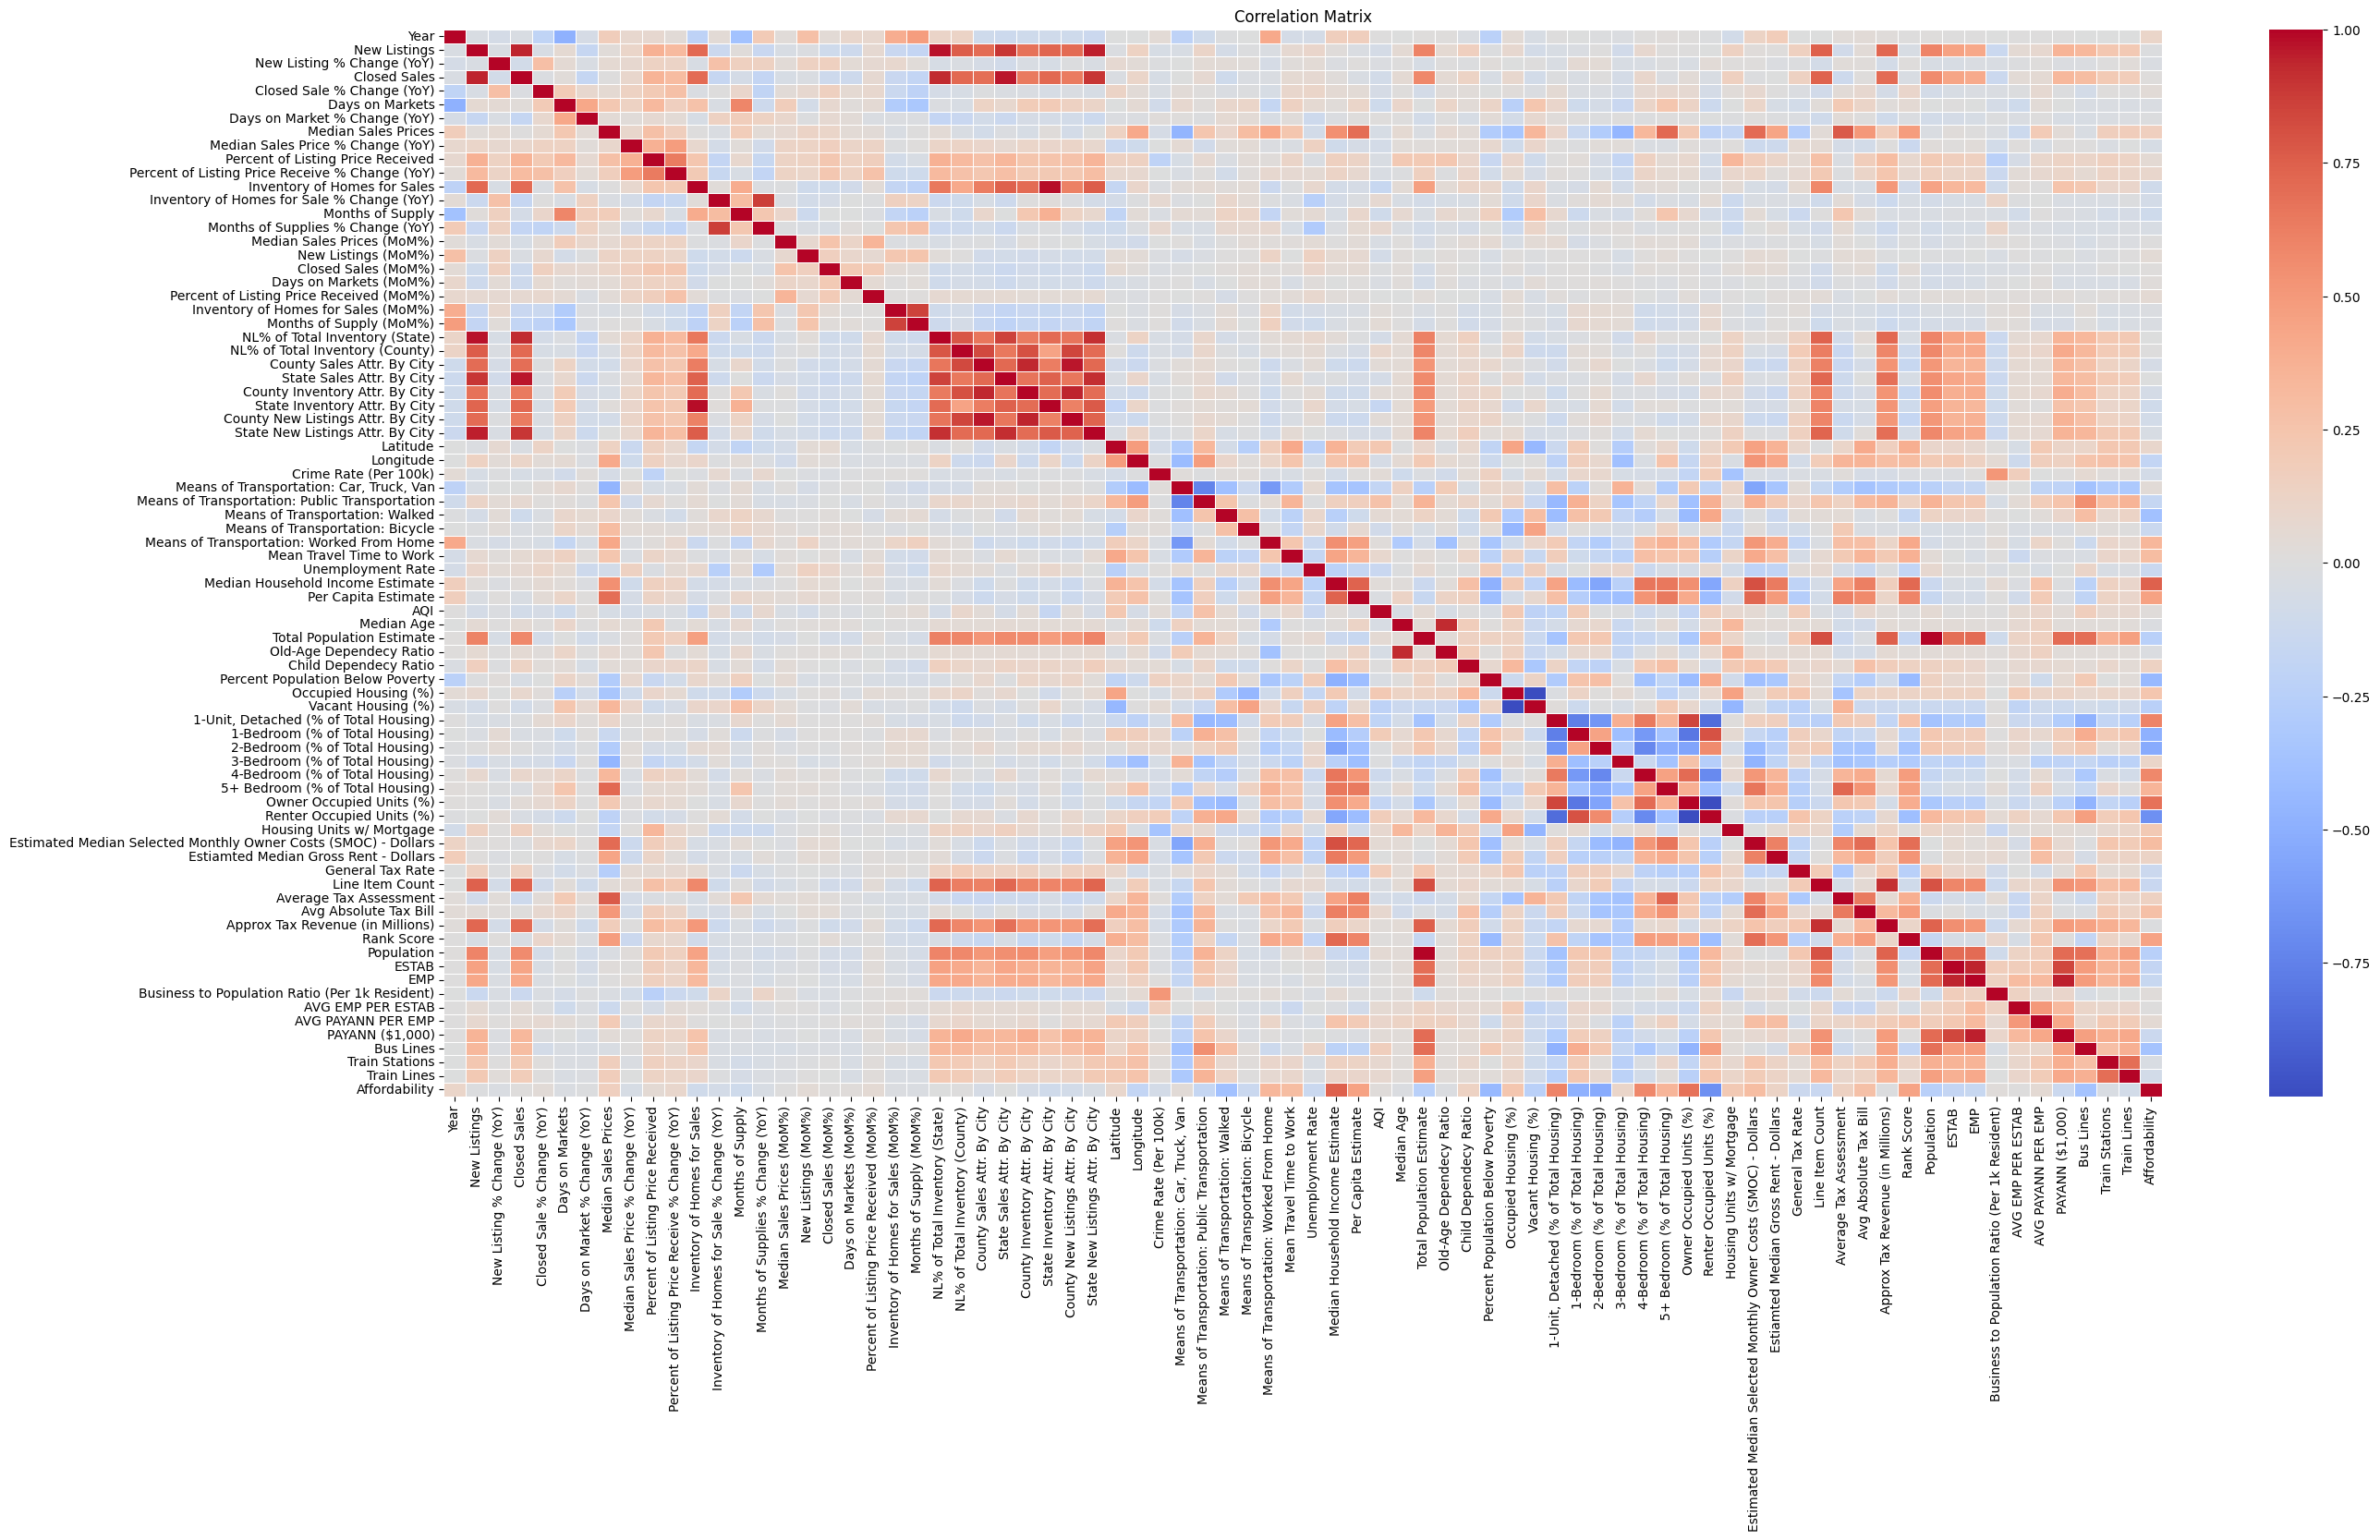

In [ ]:
plt.figure(figsize=(30,15))
correlation_matrix = test_df[[column for column in test_df.columns if column not in ['Municipality', 'County', 'Quarter', 'Month', 'Date'] and 'Z-Score' not in column]].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidth=0.5)
plt.title('Correlation Matrix')
plt.show()

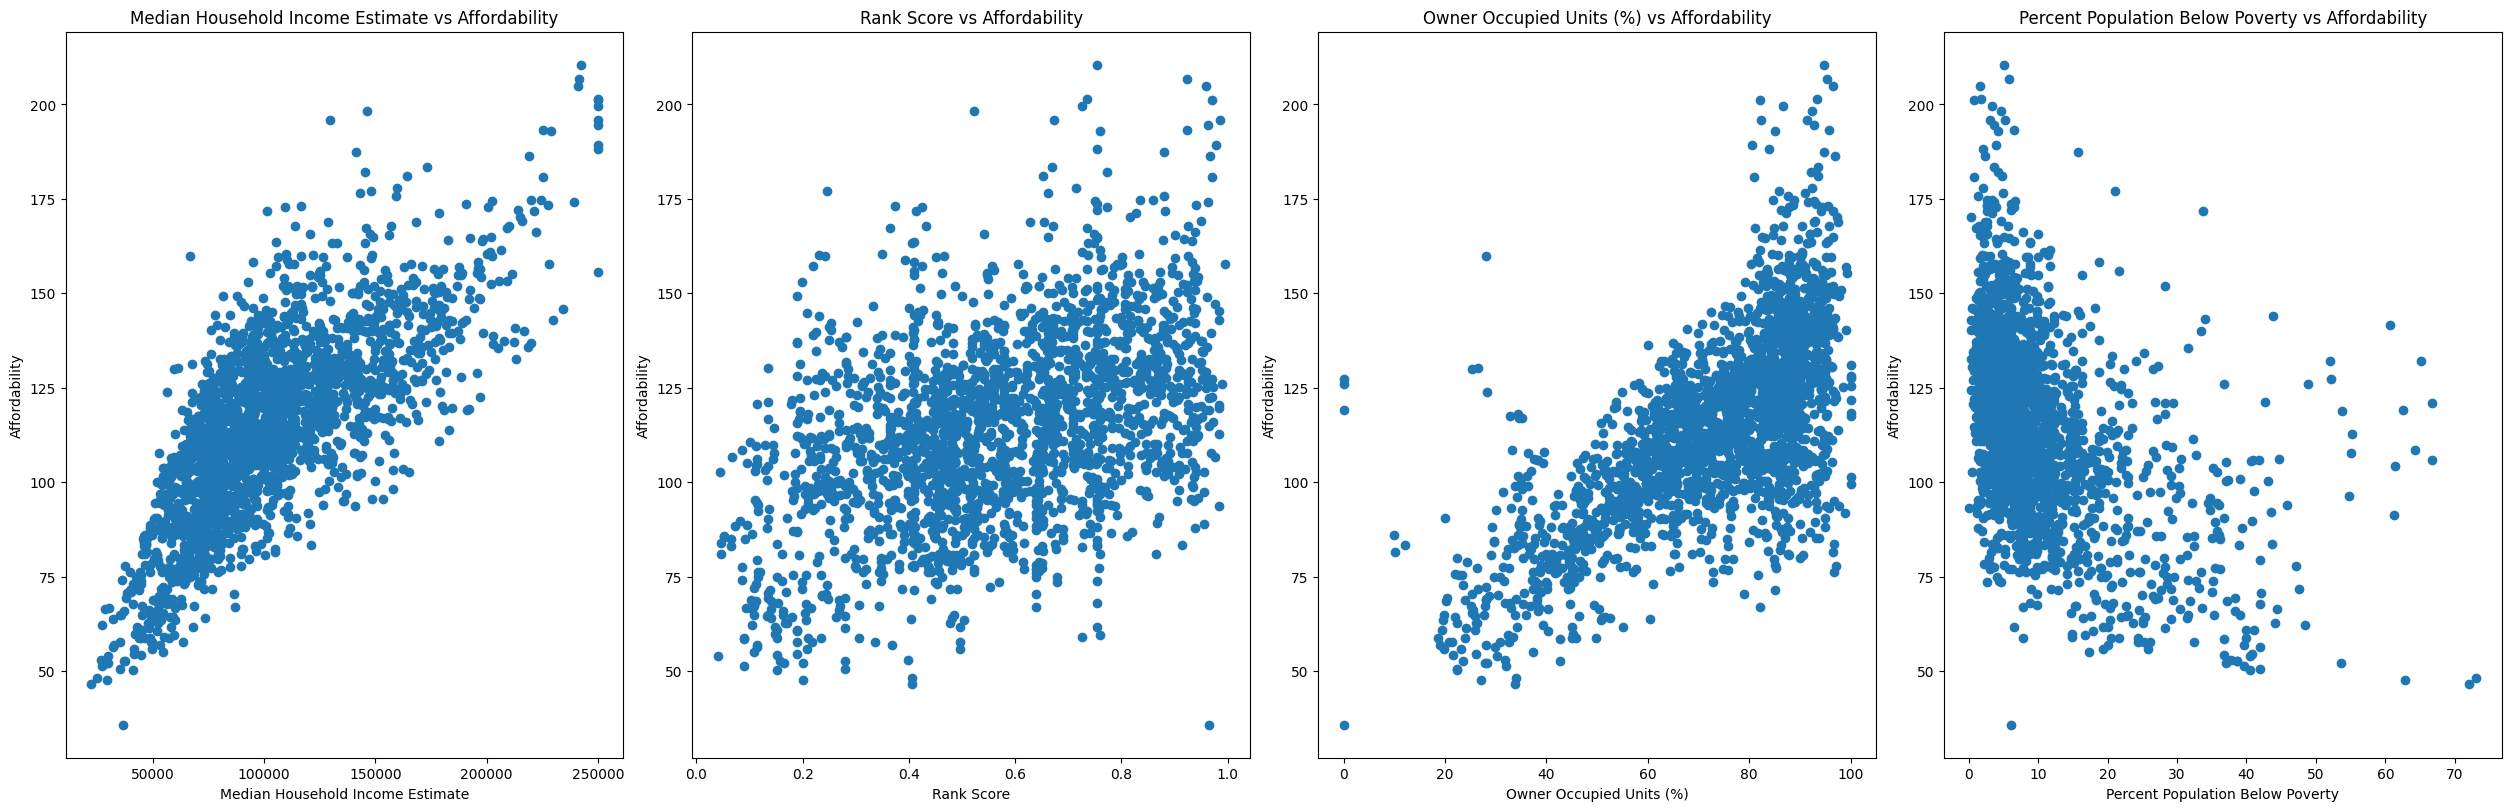

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, layout='constrained', figsize=(25,8))

for idx, column in enumerate(['Median Household Income Estimate', 'Rank Score', 'Owner Occupied Units (%)', 'Percent Population Below Poverty']):
  axs[idx].scatter(test_df[column], test_df['Affordability'])
  axs[idx].set_xlabel(column)
  axs[idx].set_ylabel('Affordability')
  axs[idx].set_title(f'{column} vs Affordability')

plt.show()
save_picture(fig, 'Affordability Scatter Plots')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


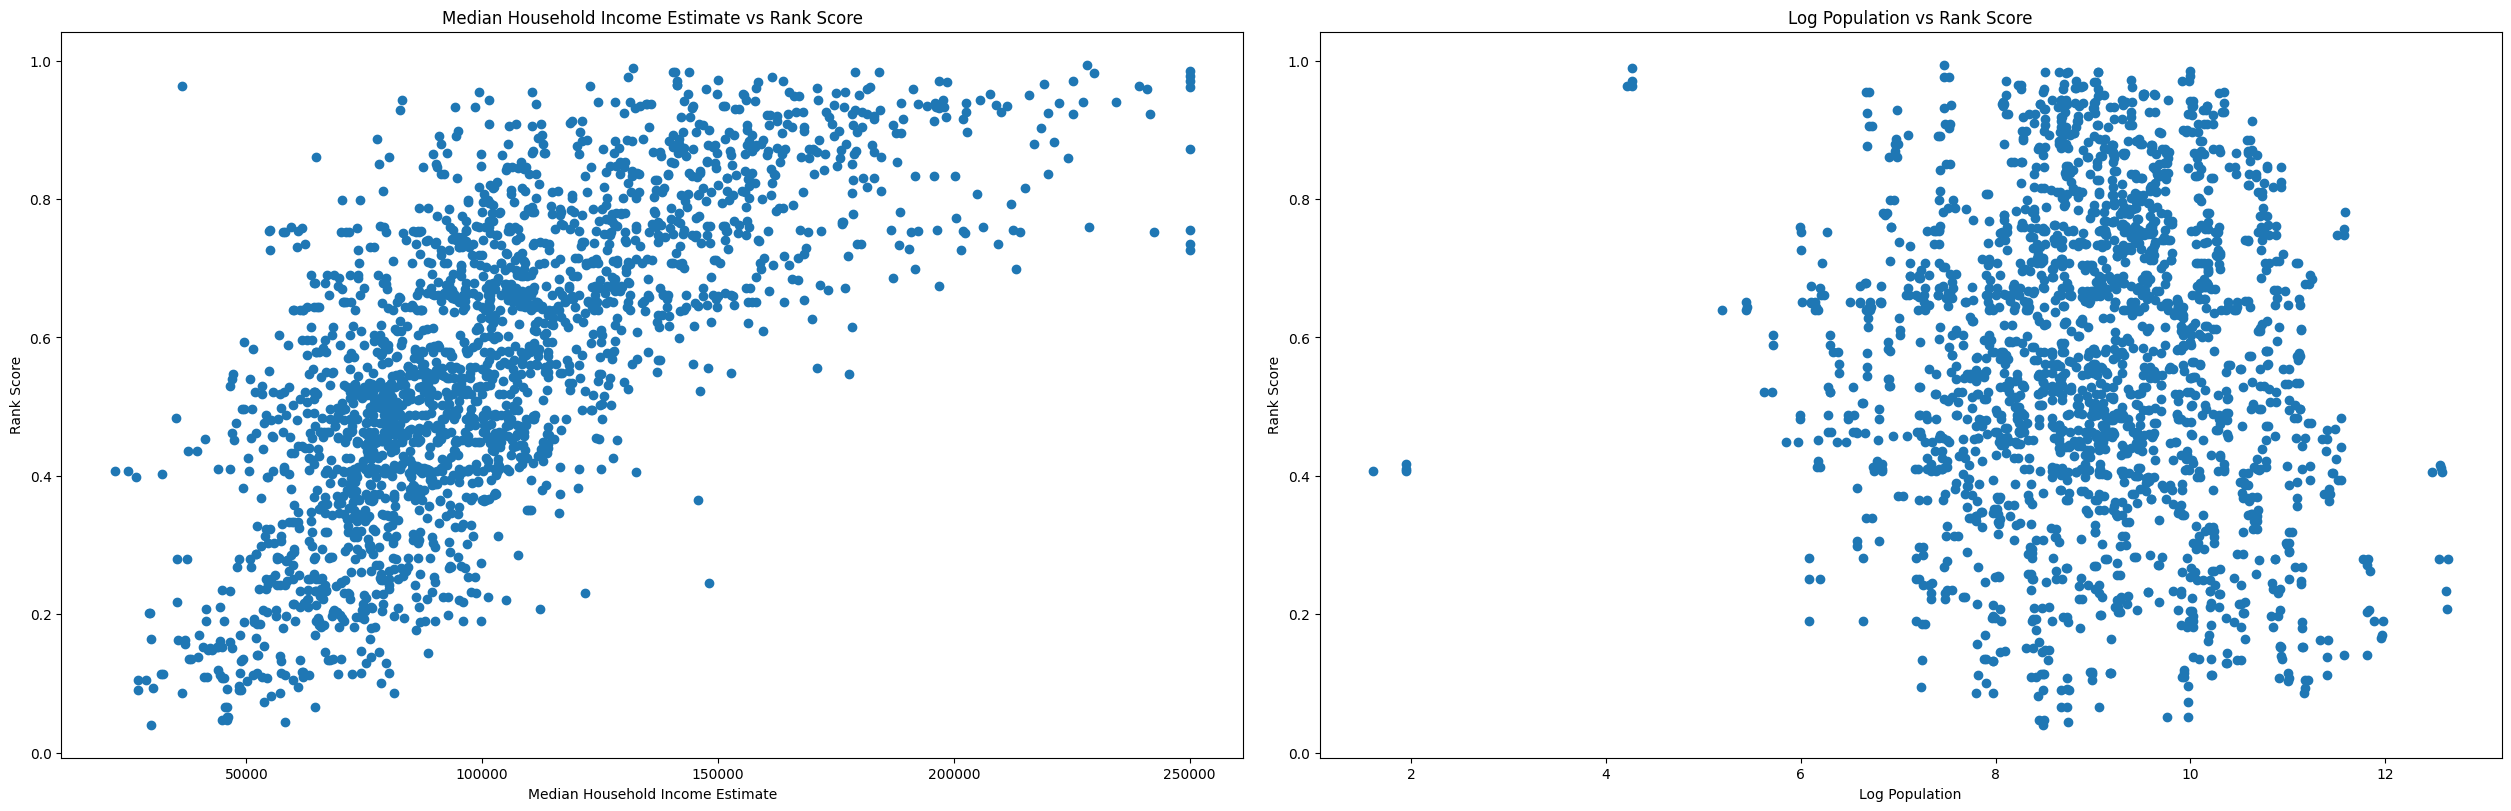

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, layout='constrained', figsize=(25,8))

for idx, column in enumerate(['Median Household Income Estimate',  'Population']):
  if column == 'Population':
    axs[idx].scatter(np.log(test_df[column]), test_df['Rank Score'])
    axs[idx].set_xlabel('Log ' + column)
    axs[idx].set_title(f'{"Log " + column} vs Rank Score')
  else:
    axs[idx].scatter(test_df[column], test_df['Rank Score'])
    axs[idx].set_xlabel(column)
    axs[idx].set_title(f'{column} vs Rank Score')

  axs[idx].set_ylabel('Rank Score')

plt.show()
save_picture(fig, 'Rank Score Scatter Plots')

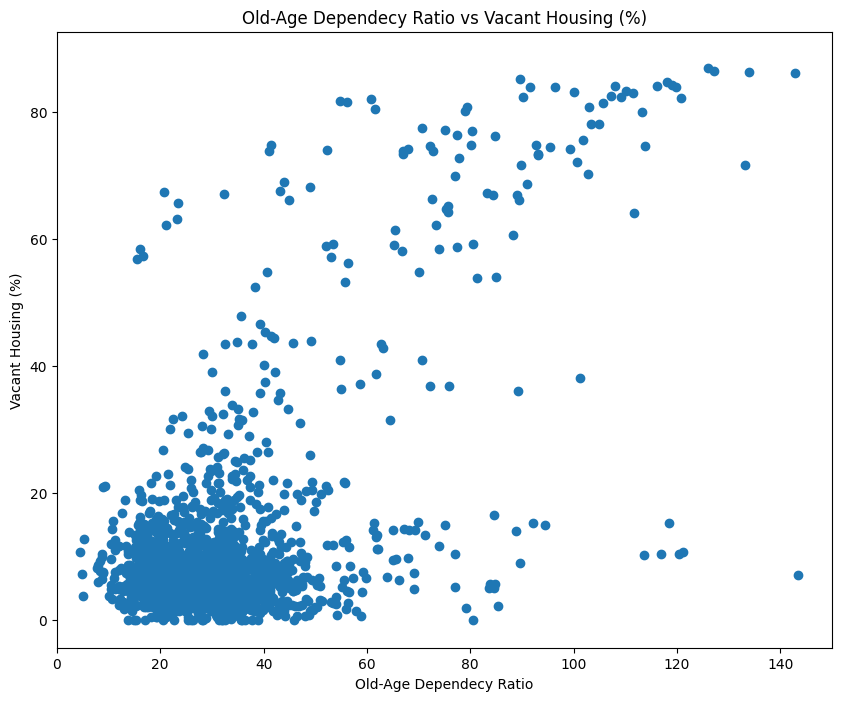

In [ ]:
fig, axs = plt.subplots(figsize=(10,8))

axs.scatter(test_df['Old-Age Dependecy Ratio'], test_df['Vacant Housing (%)'])
axs.set_xlabel('Old-Age Dependecy Ratio')
axs.set_ylabel('Vacant Housing (%)')
axs.set_title('Old-Age Dependecy Ratio vs Vacant Housing (%)')
axs.set_xlim(0,150)
plt.show()
save_picture(fig, 'Old-Age Dependecy Ratio vs Vacant Housing (%)')

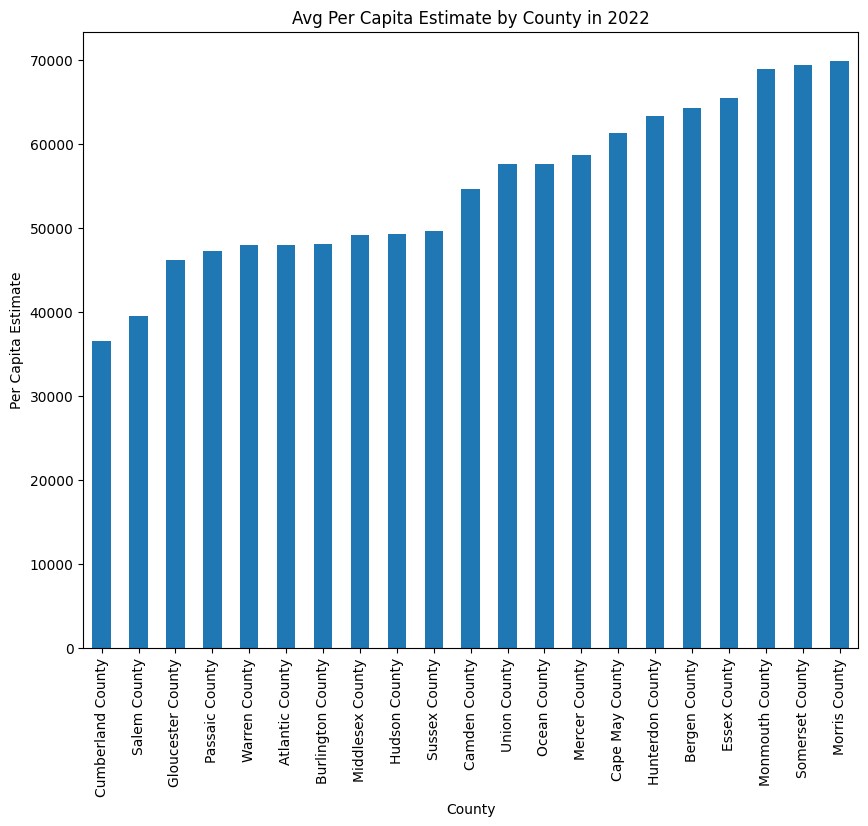

In [ ]:
fig, axs = plt.subplots(figsize=(10,8))
group = test_df[test_df['Year'] == 2022].groupby(['County'])['Per Capita Estimate'].mean().sort_values(ascending=True)
group.plot(kind='bar')
axs.set_xlabel('County')
axs.set_ylabel('Per Capita Estimate')
axs.set_title('Avg Per Capita Estimate by County in 2022')
plt.show()
save_picture(fig, 'Avg Per Capita Estimate by County in 2022')

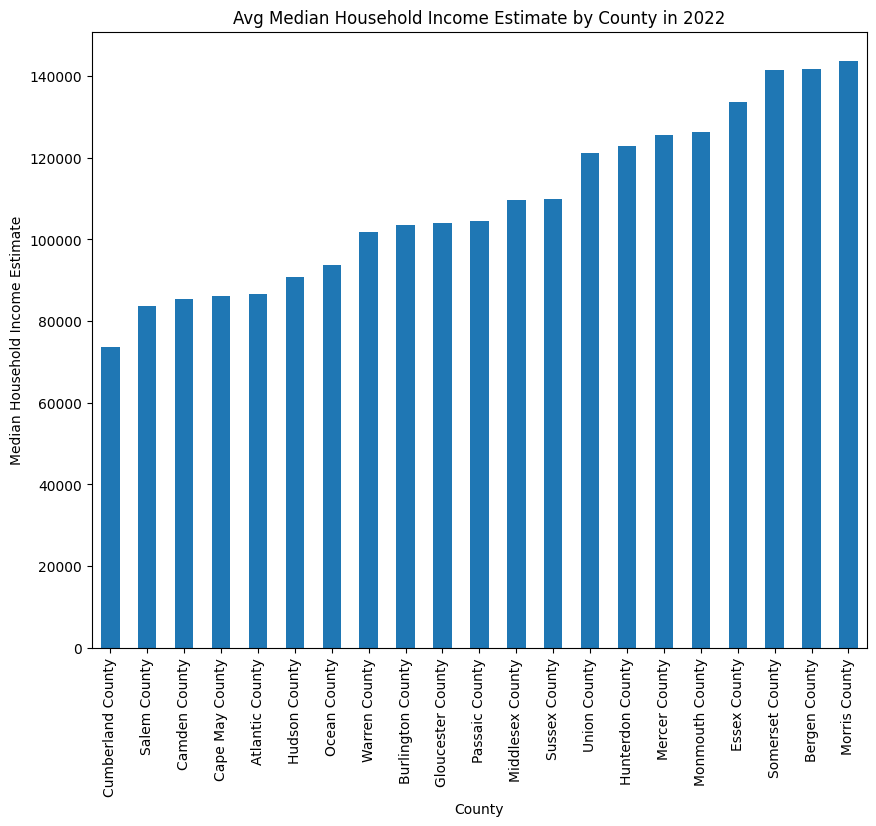

In [ ]:
fig, axs = plt.subplots(figsize=(10,8))
group = test_df[test_df['Year'] == 2022].groupby(['County'])['Median Household Income Estimate'].mean().sort_values(ascending=True)
group.plot(kind='bar')
axs.set_xlabel('County')
axs.set_ylabel('Median Household Income Estimate')
axs.set_title('Avg Median Household Income Estimate by County in 2022')
plt.show()
save_picture(fig, 'Avg Median Household Income Estimate by County in 2022')

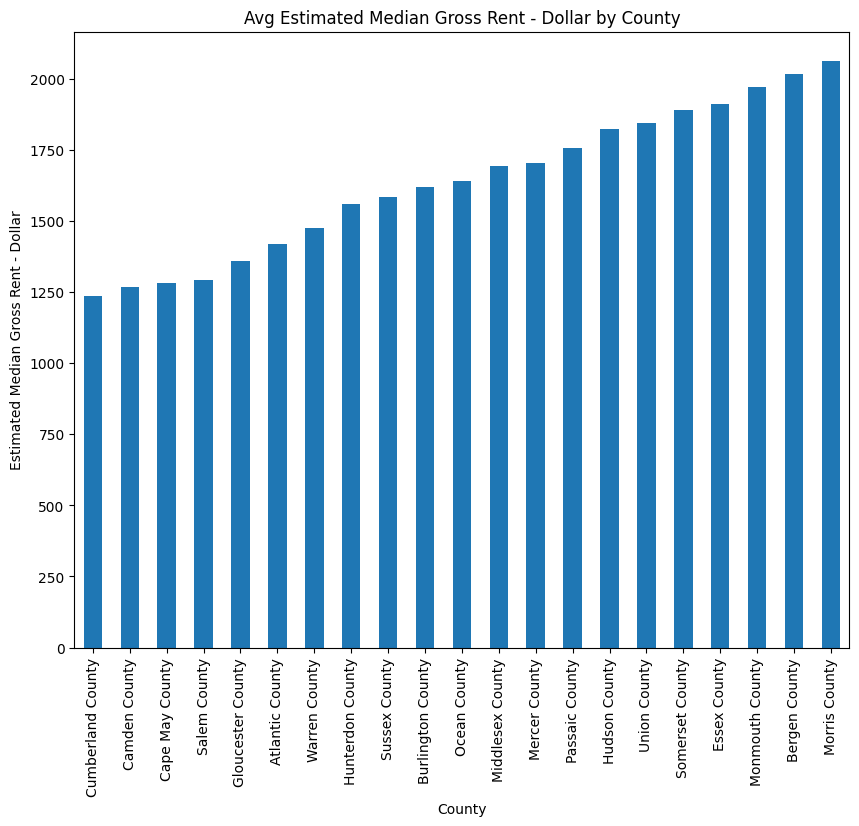

In [ ]:
fig, axs = plt.subplots(figsize=(10,8))
group = test_df[test_df['Year'] == 2022].groupby(['County'])['Estiamted Median Gross Rent - Dollars'].mean().sort_values(ascending=True)
group.plot(kind='bar')
axs.set_xlabel('County')
axs.set_ylabel('Estimated Median Gross Rent - Dollar')
axs.set_title('Avg Estimated Median Gross Rent - Dollar by County')
plt.show()
save_picture(fig, 'Avg Estimated Median Gross Rent - Dollar by County')

# What is the Median Home Price for NJ by each Year?

In [ ]:
group = data.groupby(['Year'])['Median Sales Prices'].mean().round(0)
group

Year
2019    381224.0
2020    415274.0
2021    489564.0
2022    541628.0
2023    570983.0
2024    629444.0
Name: Median Sales Prices, dtype: float64

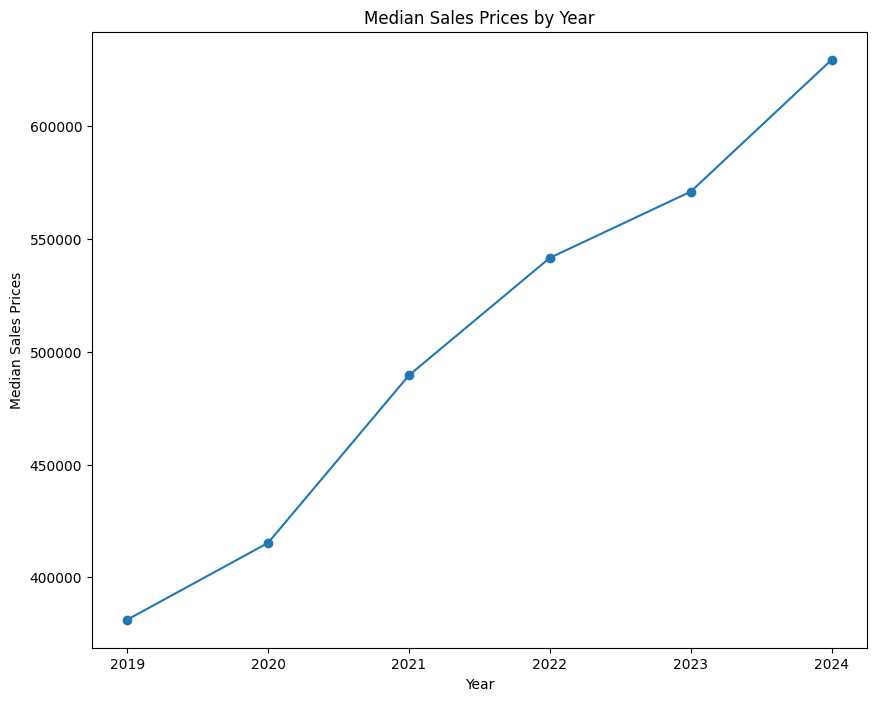

In [ ]:
fig, axs = plt.subplots(figsize=(10,8))
group.plot(kind='line', marker='o')
axs.set_xlabel('Year')
axs.set_ylabel('Median Sales Prices')
axs.set_title('Median Sales Prices by Year')
plt.show()
save_picture(fig, 'Median Sales Prices by Year')

# What Quarter Produces the Most Sales? (All Time)

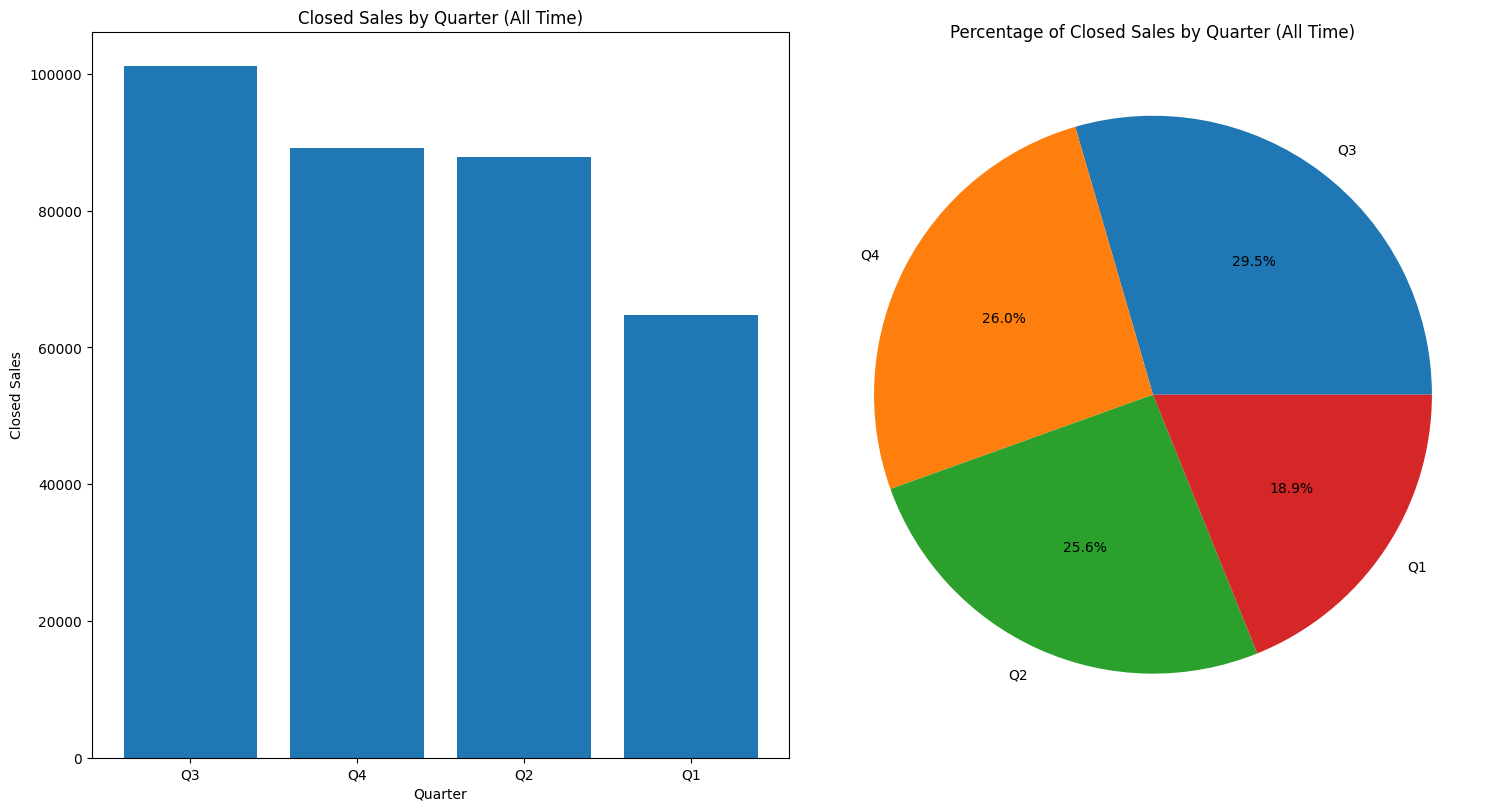

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(15,8), layout='constrained')
group = data.groupby('Quarter')['Closed Sales'].sum().sort_values(ascending=False)
axs[0].bar(group.index, group)
axs[0].set_xlabel('Quarter')
axs[0].set_ylabel('Closed Sales')
axs[0].set_title('Closed Sales by Quarter (All Time)')
axs[1].pie(group.values, labels=group.index, autopct='%1.1f%%')
axs[1].set_title('Percentage of Closed Sales by Quarter (All Time)')
plt.show()
save_picture(fig, 'Closed Sales by Quarter (All Time)')

#What Month Produces the Most Sales? (All Time)

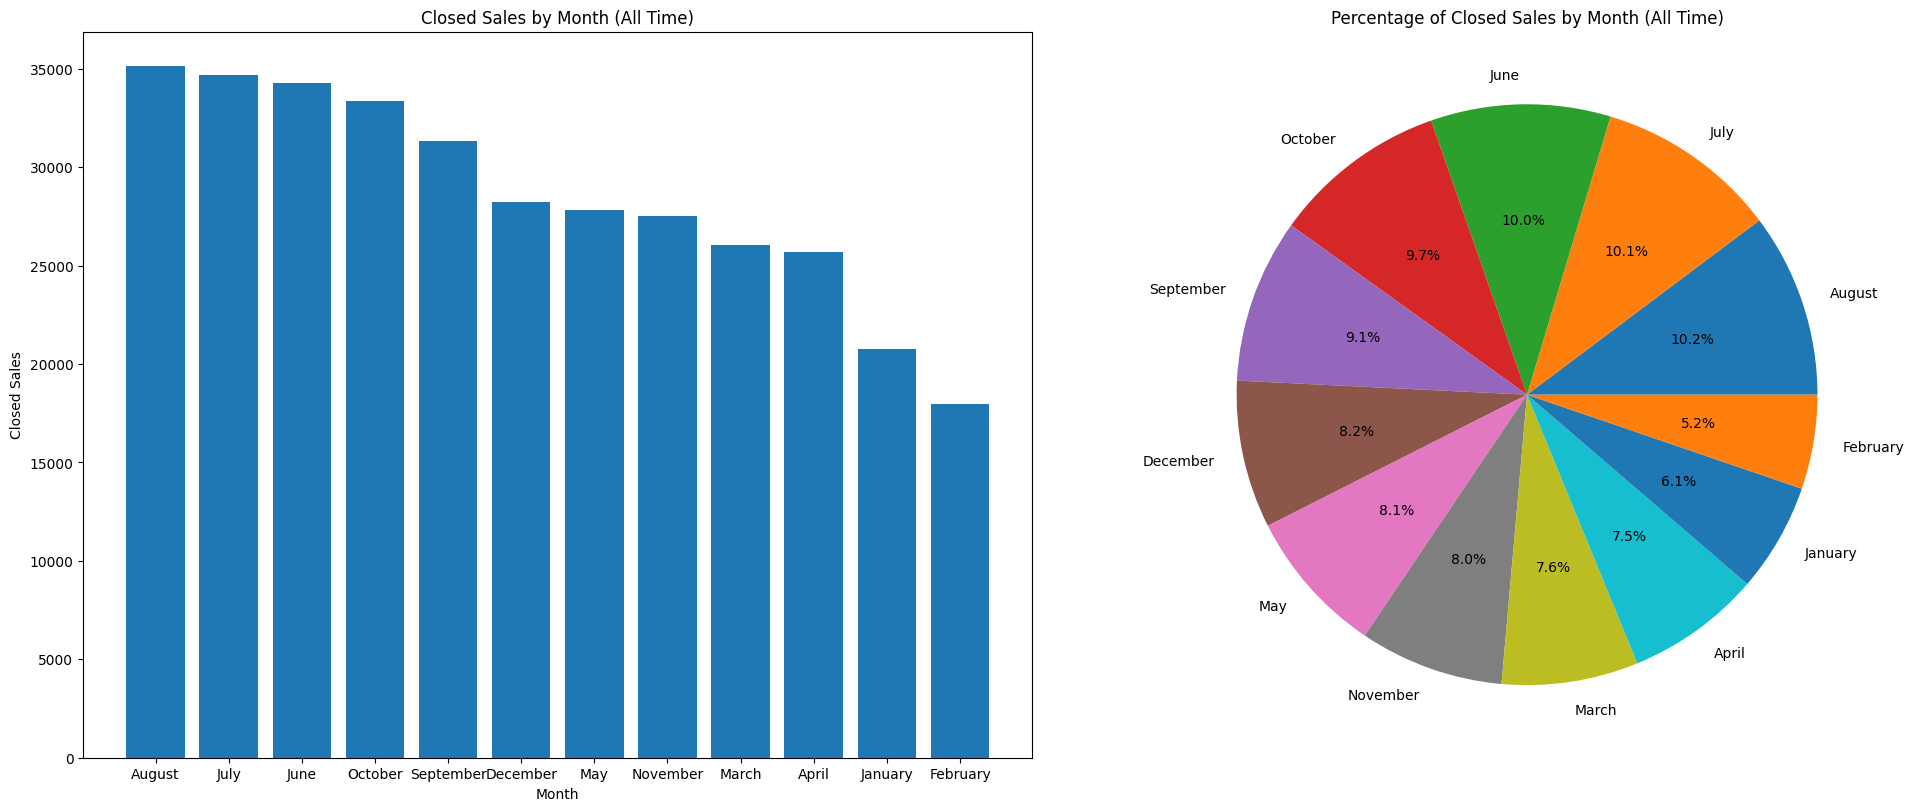

In [ ]:
fig ,axs = plt.subplots(ncols=2, figsize=(20,8), layout='constrained')
group = data.groupby('Month')['Closed Sales'].sum().sort_values(ascending=False)
axs[0].bar(group.index, group)
plt.xticks(rotation=65)
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Closed Sales')
axs[0].set_title('Closed Sales by Month (All Time)')
axs[1].pie(group.values, labels=group.index, autopct='%1.1f%%')
axs[1].set_title('Percentage of Closed Sales by Month (All Time)')

plt.show()
save_picture(fig, 'Closed Sales by Month (All Time)')

# Time Series of New Listings, Closed Sales and Inventory since 2019

In [ ]:
target_df = data[['Date', 'New Listings', 'Closed Sales', 'Inventory of Homes for Sales']]
target_df = target_df.sort_values(by='Date')
group = target_df.groupby('Date').sum()
group = group.reset_index(names='Date')



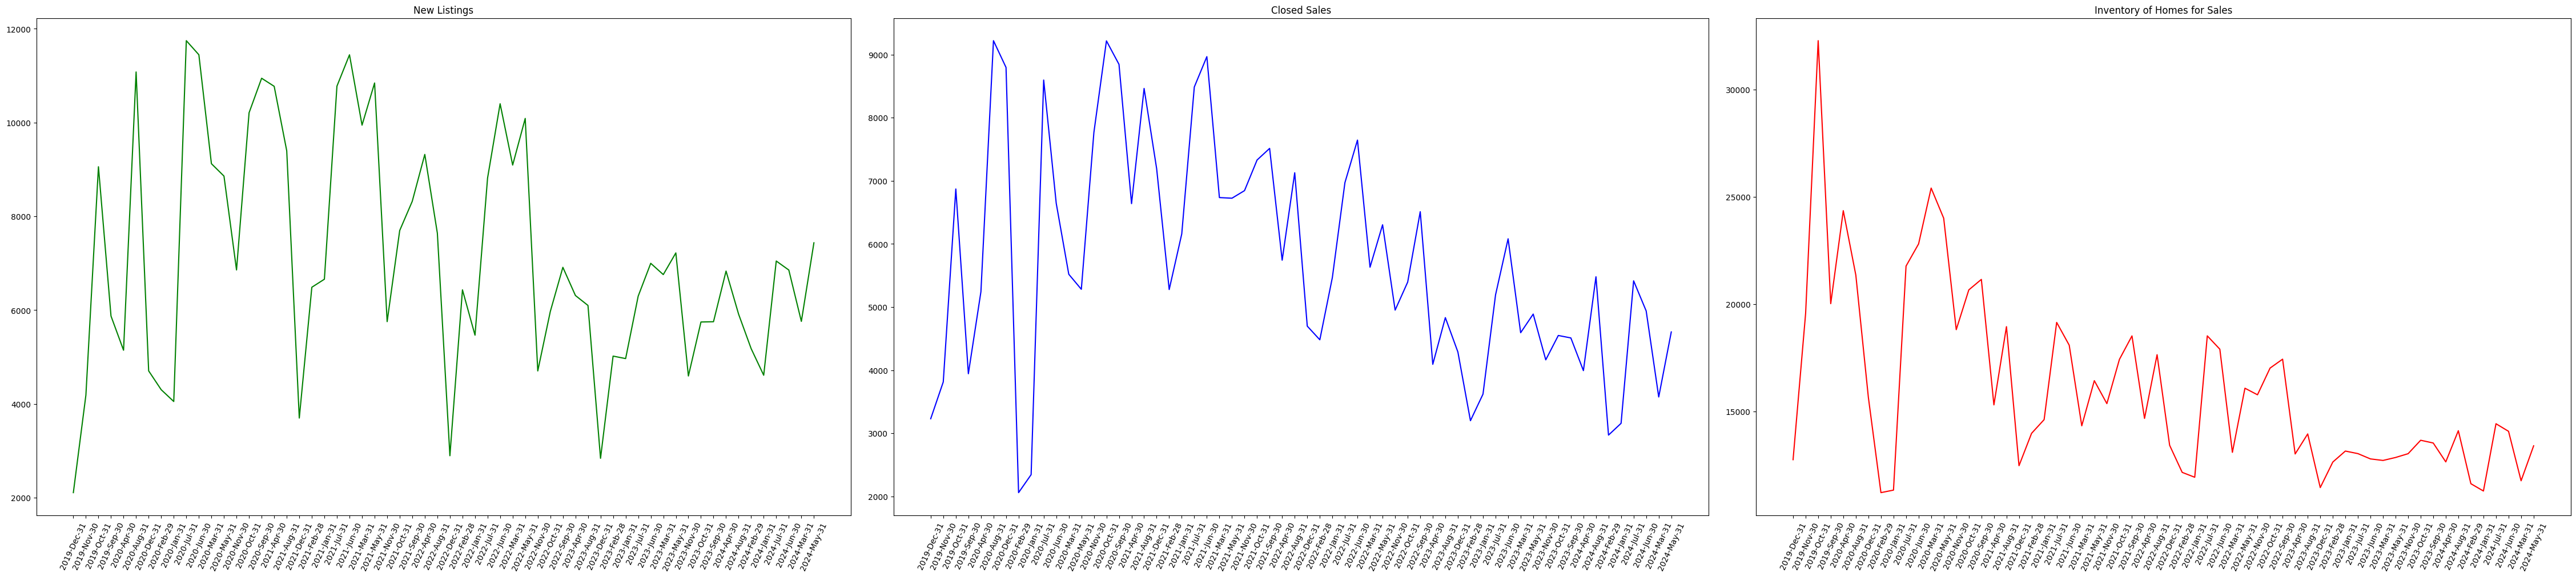

In [ ]:
target_columns = [i for i in target_df.columns if i != 'Date']
colors = ['green', 'blue', 'red']

fig, axs = plt.subplots(ncols=3, figsize=(45,10), layout='constrained')
for idx, column in enumerate(target_columns):
  axs[idx].tick_params(axis='x', labelrotation=65)
  axs[idx].plot(group['Date'], group[column], color=colors[idx])
  axs[idx].set_title(column)

# plt.xticks(rotation=65)
plt.show()
save_picture(fig, 'Time Series of New Listings, Closed Sales and Inventory since 2019')

# Latitutde and Longitude Plot of Closed Sales

In [ ]:
final_df = test_df.copy()

In [ ]:
final_df['Municipality'] = final_df['Municipality'].str.upper()
final_df['County'] = final_df['County'].str.upper()
final_df = final_df.rename(columns={'Municipality' : 'MUN', 'County': 'COUNTY'})
final_df.head()

MUN           COUNTY  Year  New Listings  \
0  ABERDEEN TWP  MONMOUTH COUNTY  2019     12.500000   
1  ABERDEEN TWP  MONMOUTH COUNTY  2020     19.090909   
2  ABERDEEN TWP  MONMOUTH COUNTY  2021     17.833333   
3  ABERDEEN TWP  MONMOUTH COUNTY  2022     16.000000   
4  ABSECON CITY  ATLANTIC COUNTY  2019     12.333333   

   New Listing % Change (YoY)  Closed Sales  Closed Sale % Change (YoY)  \
0                   -0.311500     14.000000                   -0.176250   
1                    0.102182     14.727273                    0.000182   
2                   -0.023250     16.083333                    0.243333   
3                   -0.088000     12.083333                   -0.340083   
4                    0.007000     14.333333                    0.065667   

   Days on Markets  Days on Market % Change (YoY)  Median Sales Prices  \
0        57.000000                       0.053250        363375.000000   
1        52.181818                       0.050091        388713.636364   
2        34.083333                      -0.258500        476864.583333   
3        31.250000                      -0.087917        535429.166667   
4        67.333333                      -0.197333        172833.333333   

   Median Sales Price % Change (YoY)  Percent of Listing Price Received  \
0                           0.055750                           0.978000   
1                           0.069273                           0.998273   
2                           0.227917                           1.022500   
3                           0.159000                           1.027833   
4                           0.097667                           0.979333   

   Percent of Listing Price Receive % Change (YoY)  \
0                                        -0.015250   
1                                         0.022000   
2                                         0.028333   
3                                         0.006417   
4                                         0.012000   

   Inventory of Homes for Sales  Inventory of Homes for Sale % Change (YoY)  \
0                     39.500000                                   -0.215250   
1                     31.090909                                   -0.447182   
2                     22.833333                                   -0.431083   
3                     29.000000                                   -0.202000   
4                     84.666667                                   -0.179000   

   Months of Supply  Months of Supplies % Change (YoY)  \
0          2.525000                          -0.269000   
1          2.100000                          -0.411636   
2          1.391667                          -0.498833   
3          2.108333                           0.106000   
4          6.200000                          -0.178667   

   Median Sales Prices (MoM%)  New Listings (MoM%)  Closed Sales (MoM%)  \
0                   -0.022591            -0.223178             0.017749   
1                    0.025417             0.032822             0.164538   
2                    0.020368             0.077641             0.131135   
3                    0.023311             0.077277             0.189077   
4                    0.086259            -0.091667             0.233333   

   Days on Markets (MoM%)  Percent of Listing Price Received (MoM%)  \
0               -0.023810                                  0.004625   
1                0.151227                                  0.003137   
2                0.075500                                  0.002372   
3                0.103401                                 -0.002450   
4                0.131293                                 -0.010813   

   Inventory of Homes for Sales (MoM%)  Months of Supply (MoM%)  \
0                            -0.107463                -0.089637   
1                            -0.039063                -0.043888   
2                            -0.001872                 0.004797   
3                             0.1

In [ ]:
os.chdir('/content/drive/MyDrive/Colab_Notebooks')

In [ ]:
# Import the New Jersey Geojson dataframe for plotting
nj_geopandas = geopandas.read_file('Municipal_Boundaries_of_NJ (2).geojson')
nj_geopandas.head()

OBJECTID                       MUN      COUNTY  \
0         1             DEERFIELD TWP  CUMBERLAND   
1         2              HOPEWELL TWP  CUMBERLAND   
2         3                BUENA BORO    ATLANTIC   
3         4        PORT REPUBLIC CITY    ATLANTIC   
4         5  LOWER ALLOWAYS CREEK TWP       SALEM   

                       MUN_LABEL  MUN_TYPE                           NAME  \
0             Deerfield Township  Township             Deerfield Township   
1              Hopewell Township  Township              Hopewell Township   
2                  Buena Borough   Borough                  Buena Borough   
3             Port Republic City      City                  Port Republic   
4  Lower Alloways Creek Township  Township  Lower Alloways Creek Township   

                          GNIS_NAME    GNIS   SSN MUN_CODE  CENSUS2020  \
0             Township of Deerfield  882054  0603     0603  3401116900   
1              Township of Hopewell  882056  0607     0607  3401133120   
2                  Borough of Buena  885173  0104     0104  3400108680   
3             City of Port Republic  885360  0120     0120  3400160600   
4  Township of Lower Alloways Creek  882065  1704     1705  3403341640   

  CENSUS2010         ACRES   SQ_MILES  POP2020  POP2010  POP2000  POP1990  \
0       None  10802.125430  16.878321     3136     3119     2927     2933   
1       None  19771.855017  30.893523     4391     4571     4434     4215   
2       None   4845.789976   7.571547     4501     4603     3873     4441   
3       None   5475.508796   8.555482     1101     1115     1037      992   
4       None  30679.939646  47.937406     1717     1770     1851     1858   

   POP1980  POPDEN2020  POPDEN2010  POPDEN2000  POPDEN1990  POPDEN1980  \
0     2523         186         185         173         174         149   
1     4365         142         148         144         136         141   
2     3642         594         608         512         587         481   
3      837         129         130         121         116          98   
4     1547          36          37          39          39          32   

    Shape_Length    Shape_Area  \
0   99759.458856  4.705406e+08   
1  194514.875121  8.612620e+08   
2   65896.479506  2.110826e+08   
3   91149.091766  2.385132e+08   
4  272851.442614  1.336418e+09   

                                            geometry  
0  POLYGON ((-75.11174 39.47607, -75.17368 39.518...  
1  POLYGON ((-75.23526 39.44679, -75.23528 39.446...  
2  POLYGON ((-74.92932 39.5494, -74.92947 39.5522...  
3  POLYGON ((-74.44177 39.54265, -74.442 39.54279...  
4  POLYGON ((-75.45244 39.5269, -75.46018 39.5557...

In [ ]:
nj_geopandas['Temp'] = 'COUNTY'
nj_geopandas['COUNTY'] = nj_geopandas['COUNTY'].str.cat(nj_geopandas['Temp'], sep=' ')
nj_geopandas.drop(columns='Temp', inplace=True)
nj_geopandas.head()

OBJECTID                       MUN             COUNTY  \
0         1             DEERFIELD TWP  CUMBERLAND COUNTY   
1         2              HOPEWELL TWP  CUMBERLAND COUNTY   
2         3                BUENA BORO    ATLANTIC COUNTY   
3         4        PORT REPUBLIC CITY    ATLANTIC COUNTY   
4         5  LOWER ALLOWAYS CREEK TWP       SALEM COUNTY   

                       MUN_LABEL  MUN_TYPE                           NAME  \
0             Deerfield Township  Township             Deerfield Township   
1              Hopewell Township  Township              Hopewell Township   
2                  Buena Borough   Borough                  Buena Borough   
3             Port Republic City      City                  Port Republic   
4  Lower Alloways Creek Township  Township  Lower Alloways Creek Township   

                          GNIS_NAME    GNIS   SSN MUN_CODE  CENSUS2020  \
0             Township of Deerfield  882054  0603     0603  3401116900   
1              Township of Hopewell  882056  0607     0607  3401133120   
2                  Borough of Buena  885173  0104     0104  3400108680   
3             City of Port Republic  885360  0120     0120  3400160600   
4  Township of Lower Alloways Creek  882065  1704     1705  3403341640   

  CENSUS2010         ACRES   SQ_MILES  POP2020  POP2010  POP2000  POP1990  \
0       None  10802.125430  16.878321     3136     3119     2927     2933   
1       None  19771.855017  30.893523     4391     4571     4434     4215   
2       None   4845.789976   7.571547     4501     4603     3873     4441   
3       None   5475.508796   8.555482     1101     1115     1037      992   
4       None  30679.939646  47.937406     1717     1770     1851     1858   

   POP1980  POPDEN2020  POPDEN2010  POPDEN2000  POPDEN1990  POPDEN1980  \
0     2523         186         185         173         174         149   
1     4365         142         148         144         136         141   
2     3642         594         608         512         587         481   
3      837         129         130         121         116          98   
4     1547          36          37          39          39          32   

    Shape_Length    Shape_Area  \
0   99759.458856  4.705406e+08   
1  194514.875121  8.612620e+08   
2   65896.479506  2.110826e+08   
3   91149.091766  2.385132e+08   
4  272851.442614  1.336418e+09   

                                            geometry  
0  POLYGON ((-75.11174 39.47607, -75.17368 39.518...  
1  POLYGON ((-75.23526 39.44679, -75.23528 39.446...  
2  POLYGON ((-74.92932 39.5494, -74.92947 39.5522...  
3  POLYGON ((-74.44177 39.54265, -74.442 39.54279...  
4  POLYGON ((-75.45244 39.5269, -75.46018 39.5557...

In [ ]:
muni_list = set(final_df['MUN'].unique().tolist())
geo_muni_list = set(nj_geopandas['MUN'].unique().tolist())

In [ ]:
# The following municipalities exists in the geopandas df but not in the target df
# There are small discrepancies between the way municipality names are typed in NJ Realtor and the GeoJSON
geo_muni_list.difference(muni_list)

{'AVON-BY-THE-SEA BORO',
 'BELVIDERE TOWN',
 'CALDWELL BORO',
 'CITY OF ORANGE TWP',
 'ESSEX FELLS BORO',
 'GLEN RIDGE BORO',
 'HO-HO-KUS BORO',
 'LAKE COMO BORO',
 'MANTOLOKING BORO',
 'PEAPACK-GLADSTONE BORO',
 'PRINCETON',
 'SOUTH ORANGE VILLAGE TWP',
 'WESTFIELD TOWN'}

In [ ]:
def create_geopandas_obj(df, geo_df, year: int):
  df = df[df['Year'] == year]

  return geo_df.merge(df, on=['MUN', 'COUNTY'])

In [ ]:
geo_df = create_geopandas_obj(final_df, nj_geopandas, 2022)
geo_df.head()

OBJECTID                       MUN             COUNTY  \
0         1             DEERFIELD TWP  CUMBERLAND COUNTY   
1         2              HOPEWELL TWP  CUMBERLAND COUNTY   
2         3                BUENA BORO    ATLANTIC COUNTY   
3         4        PORT REPUBLIC CITY    ATLANTIC COUNTY   
4         5  LOWER ALLOWAYS CREEK TWP       SALEM COUNTY   

                       MUN_LABEL  MUN_TYPE                           NAME  \
0             Deerfield Township  Township             Deerfield Township   
1              Hopewell Township  Township              Hopewell Township   
2                  Buena Borough   Borough                  Buena Borough   
3             Port Republic City      City                  Port Republic   
4  Lower Alloways Creek Township  Township  Lower Alloways Creek Township   

                          GNIS_NAME    GNIS   SSN MUN_CODE  CENSUS2020  \
0             Township of Deerfield  882054  0603     0603  3401116900   
1              Township of Hopewell  882056  0607     0607  3401133120   
2                  Borough of Buena  885173  0104     0104  3400108680   
3             City of Port Republic  885360  0120     0120  3400160600   
4  Township of Lower Alloways Creek  882065  1704     1705  3403341640   

  CENSUS2010         ACRES   SQ_MILES  POP2020  POP2010  POP2000  POP1990  \
0       None  10802.125430  16.878321     3136     3119     2927     2933   
1       None  19771.855017  30.893523     4391     4571     4434     4215   
2       None   4845.789976   7.571547     4501     4603     3873     4441   
3       None   5475.508796   8.555482     1101     1115     1037      992   
4       None  30679.939646  47.937406     1717     1770     1851     1858   

   POP1980  POPDEN2020  POPDEN2010  POPDEN2000  POPDEN1990  POPDEN1980  \
0     2523         186         185         173         174         149   
1     4365         142         148         144         136         141   
2     3642         594         608         512         587         481   
3      837         129         130         121         116          98   
4     1547          36          37          39          39          32   

    Shape_Length    Shape_Area  \
0   99759.458856  4.705406e+08   
1  194514.875121  8.612620e+08   
2   65896.479506  2.110826e+08   
3   91149.091766  2.385132e+08   
4  272851.442614  1.336418e+09   

                                            geometry  Year  New Listings  \
0  POLYGON ((-75.11174 39.47607, -75.17368 39.518...  2022      1.416667   
1  POLYGON ((-75.23526 39.44679, -75.23528 39.446...  2022      5.000000   
2  POLYGON ((-74.92932 39.5494, -74.92947 39.5522...  2022      4.583333   
3  POLYGON ((-74.44177 39.54265, -74.442 39.54279...  2022      1.583333   
4  POLYGON ((-75.45244 39.5269, -75.46018 39.5557...  2022      0.583333   

   New Listing % Change (YoY)  Closed Sales  Closed Sale % Change (YoY)  \
0                   -0.279750      1.083333                   -0.090250   
1                    0.515417      4.666667                    0.631000   
2                   -0.126667      3.583333                   -0.265583   
3                    0.266667      0.916667                   -0.236083   
4                   -0.430583      0.333333                   -0.388917   

   Days on Markets  Days on Market % Change (YoY)  Median Sales Prices  \
0        11.166667                      -0.068250        131291.666667   
1        35.333333                       0.049417        234812.500000   
2        27.916667                      -0.129083        228187.500000   
3        53.500000                       0.357583        292333.333333   
4         5.750000                      -0.328167         68250.000000   

   Median Sales Price % Change (YoY)  Percent of Listing Price Received  \
0                           0.034833                           0.500500   
1                           0.287333                           1.006417   
2                           0.197000       

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

In [ ]:
def color_mapping():

  colors = {
      'A': 'blueviolet',
      'B': 'lime',
      'C': 'yellow',
      'D': 'orange',
      'F': 'red'
  }

  return mcolors.ListedColormap([colors[key] for key in colors.keys()])

In [ ]:
def static_choropleth_map(df, geo_df, year: int):

  axs_divider, axs1_divider, axs2_divider, axs3_divider, axs4_divider= 0, 0 , 0, 0, 0
  geo_df = create_geopandas_obj(df, geo_df, year)
  cmap = color_mapping()

  fig, (axs, axs1, axs2, axs3, axs4) = plt.subplots(1, 5, layout='constrained', figsize=(25,14))

  for ax, divider, category in zip([axs, axs1, axs2, axs3, axs4], [axs_divider, axs1_divider, axs2_divider, axs3_divider, axs4_divider], ['Affordability', 'Median Household Income Estimate', 'Rank Score', 'Median Sales Prices', 'Inventory of Homes for Sales']):

    if category != 'Quality':
      divider = make_axes_locatable(ax)
      cax = divider.append_axes('right', size='5%', pad=0.1)

    if category == 'Median Sales Prices':
      geo_df.plot(ax=ax, column=category, vmin=50000, vmax=1000000, cax=cax, legend=True).set_axis_off()

    else:
      geo_df.plot(ax=ax, column=category, cax=cax, legend=True).set_axis_off()
    ax.set_title(category)

  save_picture(fig, 'Static Choropleth Map Matrix')

  return plt.show()

In [ ]:
# rails_df = geopandas.read_file('NJTRANSIT_RAIL_LINES.geojson')
# rails_df

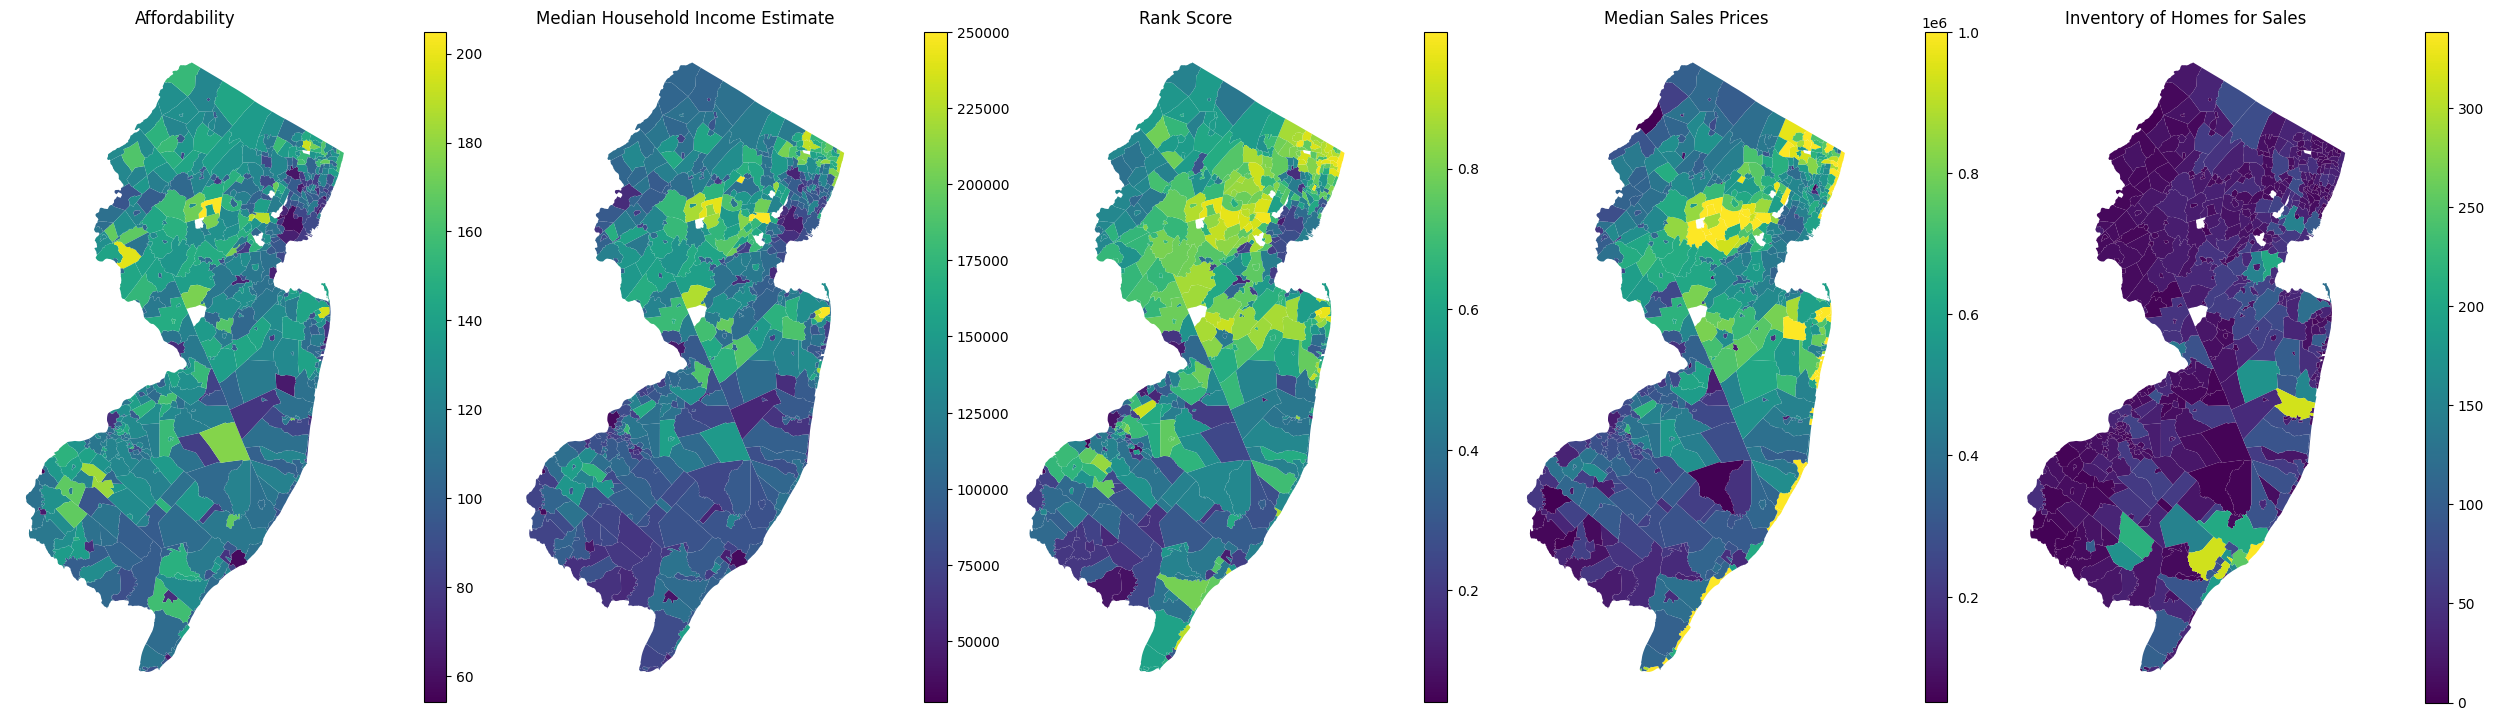

In [ ]:
static_choropleth_map(final_df, nj_geopandas, 2022)

In [ ]:
def interactive_choropleth_map(df, geo_df, column, year: int, month: str, rails='N'):

  geo_df = create_geopandas_obj(df, geo_df, year, month)
  cmap = color_mapping()

  plot = geo_df.explore(
    column=column,
    tooltip='MUN',
    popup=['MUN', 'Month', 'Median Sales Prices', 'New Listings', 'Closed Sales',
           'Inventory of Homes for Sales', 'Days on Markets', 'Percent of Listing Price Received',
           'Median Age', 'Total Population Estimate', 'Crime Rate (Per 100k)',
           'Unemployment Rate', 'Median Household Income Estimate', 'Per Capita Estimate'],
    tiles='CartoDB positron',
    # style_kwds=dict(color=geo_df['colors'].values),
    width='75%',
    height='75%',
    legend=True,
    cmap=cmap,
    name='NJ Municipalities'
    )

  # if rails == 'Y':

  #   rails_df.explore(
  #       m=plot,
  #       popup='LINE_NAME',
  #       color='black',
  #       width='75%',
  #       height='75%',
  #       name='Rail Routes'
  #   )

  #   return plot

  return plot

In [ ]:
interactive_choropleth_map(final_df, nj_geopandas, 'Quality', 2022, 'July', rails='N')

In [ ]:
# schema = pd.io.sql.get_schema(new_df, 'nj_realtor_final_v2', con=engine)
# print(schema)

In [ ]:
# schema = pd.io.sql.get_schema(nj_geopandas, 'nj_geopandas', con=engine)
# print(schema)

In [ ]:
import json

In [ ]:
geo_json = json.loads(geo_df.to_json())

# Compute the initial view of the map
# initial_view = compute_view(centroids)
initial_view = pdk.ViewState(latitude=39.833851, longitude=-74.871826, zoom=11, max_zoom=16, pitch=45, bearing=0)

column='POP2020'
max_value = geo_df[column].max()

# Define the Layer generated on the map
layer1 = pdk.Layer(
  'GeoJsonLayer',
  data=geo_json,
  opacity=0.5,
  stroked=True,
  filled=True,
  extruded=True,
  pickable=True,
  auto_highlight=True,
  get_elevation=f"(properties.{column}) / {max_value}",
  elevation_scale=10000,
  get_fill_color=f"[255, (properties.{column} / {max_value}) * 255, 100]"
)

layer2 = pdk.Layer(
    'PolygonLayer',
    data=[[-75.592927, 41.357565], [-73.890363, 38.855893]],
    stroked=False,
    # processes the data as a flat longitude-latitude pair
    get_polygon="-",
    get_fill_color=[0, 0, 0, 20],
)

In [ ]:
from google.colab import output

In [ ]:
pdk.Deck(
  layers=[layer2, layer1],
  initial_view_state=initial_view,
  map_style='dark',
  tooltip={
      'text': '''
              {properties.NAME}
              Median Sales Price: {properties.Median Sales Prices}
              New Listings: {properties.New Listings}
              Closed Sales: {properties.Closed Sales}
              Inventory of Homes for Sales: {properties.Inventory of Homes for Sales}
      '''
  }

).show()

# output.eval_js("google.colab.output.setIframeHeight(0, true, {maxHeight: 500})")
# output.serve_kernel_port_as_iframe(8000, 'test.html')